### Preprocessing the TMS dataset

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import sklearn
from anndata import read_h5ad
import anndata
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
parameters = {"myeloid" : True, 
              "non_myeloid" : True,
              
              "min_genes" : 250,
              "max_genes" : 6000, #??
              "min_transcripts" : 200,
              "max_transcripts" : 1e7,
              "min_cells" : 3, 
              
              "highly_variable_genes" : True,
              "target_sum" : 1e4,
              "min_mean" : 0.0125,
              "max_mean" : 3,
              "min_disp" : 0.2,
              
              "highly_varied_genes" : False,
              "keep_percent_genes" : 0.5,
              
              "cell_classes" : ["neuron", "macrophage", "endothelial cell", "brain pericyte", "astrocyte", "microglial cell", "oligodendrocyte"],
              "eliminate_18m" : True, 
              
              "mutual_information": False,
              "mutual_info_num" : 0.05,
              "mutual_info_path" : "aging_genes",
              
              "train_test_split" : 0.3,
              
              "compute_raw" : False,
              
              "compute_normalize" : False, # Set False if you want PCA!
              
              "compute_PCA" : True,
              "num_PCA_components" : 10,
             }
             
    
def load_tabula_muris(dir_, **kwargs):
    
    print("Loading the data...")
    
    brain = sc.read_h5ad(dir_)
    brain.var_names_make_unique()
    pd.set_option('display.max_rows', None)
    
    if kwargs["myeloid"] and kwargs["non_myeloid"]:
        brain_datasets = ["Brain_Non-Myeloid", "Brain_Myeloid"]
    elif kwargs["myeloid"]:
        brain_datasets = ["Brain_Myeloid"]
    elif kwargs["non_myeloid"]:
        brain_datasets = ["Brain_Non-Myeloid"]
    else:
        print("You need to select True for myeloid and/or non_myeloid...")
        return None, None, None, None
    
    brain_data = brain[brain.obs.tissue.isin(brain_datasets)]
    
    brain_data = brain_data[brain_data.obs['age'] != '18m']
    brain_data = brain_data[brain_data.obs['cell_ontology_class'].isin(kwargs['cell_classes'])]
 
    print("Data loaded (dimension:", brain_data.shape, ")!")
    
    print("Removing cells and genes...")

    # Remove cells with too many or too little expressed genes
    brain_data = brain_data[brain_data.obs.n_genes > kwargs["min_genes"], :]
    brain_data = brain_data[brain_data.obs.n_genes < kwargs["max_genes"], :]
    
    # Remove cells with too many or too little transcript genes
    brain_data = brain_data[brain_data.obs.n_counts < kwargs["max_transcripts"], :]
    brain_data = brain_data[brain_data.obs.n_counts > kwargs["min_transcripts"], :]
    
    # Remove genes only present in less than Y % of cells
    sc.pp.filter_genes(brain_data, min_cells = kwargs["min_cells"]) 
    
    print("Highly variable gene selection...")

    # Total-count normalize the data matrix X to 10,000 reads per cell - counts are comparable among cells
    sc.pp.normalize_total(brain_data, target_sum = kwargs["target_sum"])

    # Logarithmize the data
    sc.pp.log1p(brain_data) 
    
    # Identify highly variable genes 
    sc.pp.highly_variable_genes(brain_data, min_mean = kwargs["min_mean"], max_mean = kwargs["max_mean"], 
                                min_disp = kwargs["min_disp"])

    # Filter to keep highly variable
    brain_data = brain_data[:, brain_data.var.highly_variable] 
    
    brain_data.raw = brain_data
    
    print("Data final dimension:", brain_data.shape)

    return brain_data
     
brain_data = load_tabula_muris("tabula-muris-senis-facs-official-raw-obj.h5ad", **parameters)


Loading the data...
Data loaded (dimension: (12452, 22966) )!
Removing cells and genes...
Highly variable gene selection...
Data final dimension: (12368, 9153)


In [ ]:
# Doing the grid search to find the optimal parameters for the RF classifier - nested cross-validation
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

models_param_grid = {
                    'max_depth': [20, 30],
                    'n_estimators': [200, 300],
                    'max_features' : [50, 100, 200]
                    }

clf_grid = GridSearchCV(RandomForestClassifier(), models_param_grid) # 5 fold CV
clf_grid.fit(X_train, y_train)
print("Best parameters found in the grid search: ", clf_grid.best_params_, "\n")
print("Not nested test score: ", clf_grid.best_score_, "\n") # Mean cross-validated score of the best_estimator
print("Nested CV test score: ", cross_val_score(clf_grid, X_test,y_test)) # test score from a 5-fold CV

# other hyperparameters we could consider: min_samples_split, min_samples_leaf
# min_samples_split: minimum split of the sample that we can do at a branching point
# min_samples_leaf: samples in the leaf node comes out to be more than a certain number"""

In [ ]:
"""print("Best parameters found in the grid search: ", clf_grid.best_params_, "\n")
print("Not nested test score: ", clf_grid.best_score_, "\n") # Mean cross-validated score of the best_estimator
print("Nested CV test score: ", mean(cross_val_score(clf_grid, X_test, y_test))) # test score from a 5-fold CV"""

In [ ]:
"""# Train the final model on the whole dataset

clf = RandomForestClassifier(max_depth = 20, max_features = 5, n_estimators = 300, random_state=0)
X = X_train.append(X_test)
y = y_train.append(y_test)
clf.fit(X, y)"""

In [ ]:
"""# uses Gini to determine the feature importance: how many times the feature is used to split the data, as well as the size of the samples that it splits

impfeatures = pd.DataFrame(clf.feature_importances_, columns = ['Importance'], index = X.columns.tolist()) 
impfeatures.sort_values(by='Importance', ascending=False, inplace=True)
impfeatures.head(10)"""

In [98]:
brain_data

AnnData object with n_obs × n_vars = 9291 × 8754
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### Loading Lee Rubin dataset 1st time

In [3]:
# Uploading the other dataset, and performing similar pre-processing

import zipfile
zip = zipfile.ZipFile('expression.txt.zip')
data = zip.extractall()
data = pd.read_csv('expression.txt', delimiter = '\t', chunksize = 1000)
pd_df = pd.concat(data)

# Getting the gene into the rows and cells into the columns

pd_df.index = pd_df['GENE']
pd_df.drop('GENE', axis=1, inplace=True)
pd_df = pd_df.T
pd_df.head()

GENE                                              Sox17    Mrpl15  Lypla1  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG    0.0  1.340271     0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA    0.0  0.000000     0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT    0.0  0.000000     0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT    0.0  0.000000     0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA    0.0  0.000000     0.0   

GENE                                              Tcea1  Rgs20  Atp6v1h  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA    0.0    0.0      0.0   

GENE                                              Oprk1  Rb1cc1  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG    0.0     0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA    0.0     0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT    0.0     0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT    0.0     0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA    0.0     0.0   

GENE                                              4732440D04Rik  St18  ...  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA            0.0   0.0  ...   

GENE                                                mt-Nd3   mt-Nd4l  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG  1.340271  1.340271   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA  0.000000  1.986951   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT  2.929314  0.000000   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT  1.549226  0.000000   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA  0.000000  0.000000   

GENE                                                mt-Nd4    mt-Nd5  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG  2.507998  0.000000   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA  3.480204  0.000000   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT  4.589359  0.000000   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT  3.423043  1.549226   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA  0.000000  0.000000   

GENE                                                mt-Nd6   mt-Cytb  Vamp7  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG  0.000000  3.374196    0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA  0.000000  4.337542    0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT  0.000000  4.589359    0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT  1.549226  2.972418    0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA  0.000000  0.000000    0.0   

GENE                                              AC168977.1  PISD  DHRSX  
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA         0.0   0.0    0.0  

[5 rows x 14699 columns]

In [4]:
# Determine if the columns have been normalized or not

list_cells = ['Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG', 'Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA', 'Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT']
pd_df_exp = np.exp(pd_df)-1
pd_df_exp.head()
for count, cell in enumerate(list_cells):
    print(pd_df_exp.iloc[count].sum()) # the data has be pre normalized to 1e4 and then the log was taken

10000.000000000015
10000.000000000011
9999.999999999989


In [5]:
# Put into an ANNdata format: 

rubin_data = sc.AnnData(X=pd_df.iloc[:,:])
rubin_data.var = pd.DataFrame(pd_df.columns.to_list(), columns=['gene'])
rubin_data.obs = pd.DataFrame(pd_df.index.to_list(), columns=['cell'])

sc.AnnData.write_h5ad(rubin_data, "rubin_data.h5ad")


### Loading the Rubin data and preprocessing

In [3]:
rubin_data = sc.read_h5ad("rubin_data.h5ad")

In [4]:
# add the metadata to the Lee Rubin dataset

meta = pd.read_csv("meta_Aging_mouse_brain_portal_data.txt", delimiter="\t")
meta.drop(0, axis=0, inplace=True)
rubin_data.obs['cell_type'] = meta['cell_type'].tolist()
rubin_data.obs['cell_type_by_age'] = meta['cell_type_by_age'].tolist()
rubin_data.obs['cell_class'] = meta['cell_class'].tolist()
rubin_data.obs['cell_class_by_age'] = meta['cell_class_by_age'].tolist()
rubin_data.obs['all_cells_by_age'] = meta['all_cells_by_age'].tolist()
rubin_data.obs['nGene'] = meta['nGene'].tolist()
rubin_data.obs['nUMI'] = meta['nUMI'].tolist()
rubin_data.var_names = rubin_data.var['gene']
rubin_data = rubin_data[rubin_data.obs['cell_type'].isin(['OLG', 'NEUR_mature', 'MAC', 'ASC', 'MG', 'EC', 'PC'])] #(['NEUR_mature','MAC', 'MG'])]
rubin_data.obs['cell_type'] = rubin_data.obs['cell_type'].map({'OLG': 'oligodendrocyte', 'ASC': 'astrocyte', 'NEUR_mature':'neuron', 'PC': 'brain pericyte', 'MG': 'microglial cell', 'MAC': 'macrophage', 'EC': 'endothelial cell'})

# ({'OLG': 'oligodendrocyte', 'ASC': 'astrocyte', 'NEUR_mature':'neuron', 'PC': 'brain pericyte', 'MG': 'microglial cell', 'MAC': 'macrophage', 'EC': 'endothelial cell'})

mouse_id = []
for cell in rubin_data.obs['cell']:
    mouse_id.append(cell.split('_')[5])
    
rubin_data.obs['mouse.id'] = mouse_id


### Gene overlap

In [5]:
# Need to filter the features to make sure that they are identical in the two datasets

gene_overlap = brain_data.var.index.intersection(rubin_data.var['gene'])
print("There is an overlap of ", gene_overlap.size, " of the two datasets. \n The Tabula Muris Senis had ", len(brain_data.var_names), " genes, and the Rubin dataset had ", rubin_data.var.size, " genes.")

There is an overlap of  7952  of the two datasets. 
 The Tabula Muris Senis had  9153  genes, and the Rubin dataset had  14699  genes.


In [6]:
# Final datasets for each
rubin_data.var_names = rubin_data.var['gene']
rubin_data_overlap = rubin_data[:, rubin_data.var_names.isin(gene_overlap.to_list())]
brain_data_overlap = brain_data[:, brain_data.var_names.isin(gene_overlap.to_list())]
brain_data_overlap.raw = brain_data_overlap

## Log normalize the data

In [7]:
# Log and Norm
brain_data_overlap.X.A = np.exp(brain_data_overlap.X.A) - 1
sc.pp.normalize_total(brain_data_overlap, target_sum = 10e4)
sc.pp.log1p(brain_data_overlap) 
brain_data_overlap.raw = brain_data_overlap

In [8]:
brain_data_overlap

AnnData object with n_obs × n_vars = 12368 × 7952
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [9]:
# Log and Norm
rubin_data_overlap.X = np.exp(rubin_data_overlap.X) - 1
sc.pp.normalize_total(rubin_data_overlap, target_sum = 10e4)
sc.pp.log1p(rubin_data_overlap) 
rubin_data_overlap.raw = rubin_data_overlap

## Mouse batch average

In [10]:
tabula_muris_mouse = []
ages = []

for id_ in brain_data_overlap.obs['mouse.id'].unique():
    tabula_muris_mouse.append(np.mean(brain_data_overlap[brain_data_overlap.obs['mouse.id'] == id_].X.A, axis = 0))
    ages.append(brain_data_overlap[brain_data_overlap.obs['mouse.id'] == id_].obs['age'][0])

tabula_muris_mouse     = anndata.AnnData(X = np.array(tabula_muris_mouse))
tabula_muris_mouse.obs = pd.DataFrame(ages, columns=['ages'])
tabula_muris_mouse.var = pd.DataFrame(brain_data_overlap.var_names.tolist(), columns=['gene'])
tabula_muris_mouse.var_names = brain_data_overlap.var_names

In [11]:
lee_rubin_mouse = []
ages = []

for id_ in rubin_data_overlap.obs['mouse.id'].unique():
    lee_rubin_mouse.append(np.mean(rubin_data_overlap[rubin_data_overlap.obs['mouse.id'] == id_].X, axis = 0))
    ages.append(rubin_data_overlap[rubin_data_overlap.obs['mouse.id'] == id_].obs['all_cells_by_age'][0])

lee_rubin_mouse     = anndata.AnnData(X = np.array(lee_rubin_mouse))
lee_rubin_mouse.obs = pd.DataFrame(ages, columns=['ages'])
lee_rubin_mouse.var = pd.DataFrame(rubin_data_overlap.var_names.tolist(), columns=['gene'])
lee_rubin_mouse.var_names = rubin_data_overlap.var_names

In [12]:
tabula_muris_mouse 

AnnData object with n_obs × n_vars = 11 × 7952
    obs: 'ages'
    var: 'gene'

In [13]:
lee_rubin_mouse

AnnData object with n_obs × n_vars = 16 × 7952
    obs: 'ages'
    var: 'gene'

In [36]:
""" # The cell types that are shared between the two

cell_overlap_rubin = ['OLG', 'EC', 'ASC', 'NEUR_mature', 'PC', 'MG', 'MAC']
cell_overlap_TMS = ['oligodendrocyte', 'astrocyte', 'neuron', 'brain pericyte', 'endothelial cell', ...
                    , 'microglial cell', 'macrophage']

# only keeping the cell types that are in the two datasets

rubin_data_overlap = rubin_data_overlap[rubin_data_overlap.obs['cell_type'].isin(cell_overlap_rubin), :]
brain_data_overlap = brain_data_overlap[brain_data_overlap.obs['cell_ontology_class'].isin(cell_overlap_TMS), :]

# mapping the names of the Rubin dataset into the names of the TMS cell types
rubin_data_overlap.obs['cell_type'] = rubin_data_overlap.obs['cell_type'].map({'OLG': 'oligodendrocyte', 'ASC': 'astrocyte', 'NEUR_mature':'neuron', 'PC': 'brain pericyte', 'MG': 'microglial cell', 'MAC': 'macrophage', 'EC': 'endothelial cell'}) """


" # The cell types that are shared between the two\n\ncell_overlap_rubin = ['OLG', 'EC', 'ASC', 'NEUR_mature', 'PC', 'MG', 'MAC']\ncell_overlap_TMS = ['oligodendrocyte', 'astrocyte', 'neuron', 'brain pericyte', 'endothelial cell', ...\n                    , 'microglial cell', 'macrophage']\n\n# only keeping the cell types that are in the two datasets\n\nrubin_data_overlap = rubin_data_overlap[rubin_data_overlap.obs['cell_type'].isin(cell_overlap_rubin), :]\nbrain_data_overlap = brain_data_overlap[brain_data_overlap.obs['cell_ontology_class'].isin(cell_overlap_TMS), :]\n\n#\xa0mapping the names of the Rubin dataset into the names of the TMS cell types\nrubin_data_overlap.obs['cell_type'] = rubin_data_overlap.obs['cell_type'].map({'OLG': 'oligodendrocyte', 'ASC': 'astrocyte', 'NEUR_mature':'neuron', 'PC': 'brain pericyte', 'MG': 'microglial cell', 'MAC': 'macrophage', 'EC': 'endothelial cell'}) "

In [7]:
# To compare the clustering, we will use the following markers for the different cell types

cell_markers = pd.read_excel('cell_types_5_7_22.xlsx')
cell_markers

astrocyte brain pericyte macrophage microglial cell         neuron  \
0       Gja1          Kcnj8        Pf4         Tmem119           Syt1   
1       Gfap         Pdgfrb      Cd11b            C1qb           NeuN   
2       Aqp4            Sma       Cd14            C1qa           Map2   
3        Clu          Cd146       Cd68           Csf1r          Psd95   
4    Aldh1l1           Cd13       Cd64            Ctss          Gap43   
5      Eaat1            Ng2       Ccr5           Cd11b           Nefm   
6      Eaat2         Nestin       Cd14            Cd45           Nefh   
7       Glul        Atp13a5       Cd16            Iba1            Syp   
8      S100b           Cd31       Cd71          Cx3cr1           Eno2   
9        NaN            NaN        Nos          Adgre1          Tubb3   
10       NaN            NaN       Nos2            Cd68           Map2   
11       NaN            NaN       Arg1            Cd40           Neun   
12       NaN            NaN      Cd206           Sall1          Mrx96   
13       NaN            NaN      Fizz1            Cd14          Sap90   
14       NaN            NaN       Cd38            Cd45           Dlg4   
15       NaN            NaN      Gpr18            Cd80            P38   
16       NaN            NaN       Fpr2           Cd115          Prox1   
17       NaN            NaN       Erg2          Fcer1g            Dcx   
18       NaN            NaN       cMyc          P2y12r          Cd171   
19       NaN            NaN       Cd80            Cd33          Cd271   
20       NaN            NaN       Cd86          Cd172a           Ngfr   
21       NaN            NaN      Cd11c            Cd91            Nse   
22       NaN            NaN       Cd15           Cd115  Enolase 2/NSE   
23       NaN            NaN      Cd163             Cr3           Chat   
24       NaN            NaN         F4            Cd16          Gad65   
25       NaN            NaN        F80            Cd32          Gad67   
26       NaN            NaN       Cd32            Cd86         Vglut1   
27       NaN            NaN       Cd16           Mertk         Vglut2   
28       NaN            NaN      Cd11a           MerTK           Pet1   
29       NaN            NaN     Cd107b          P2ry12           Sert   
30       NaN            NaN     Lilrb4           Cd11c           Chat   
31       NaN            NaN      Cd85k             NaN            Dcx   
32       NaN            NaN       Ilt3             NaN           Hes1   
33       NaN            NaN      Cd115             NaN             Th   
34       NaN            NaN       Cd33             NaN            Is1   
35       NaN            NaN       Tlr2             NaN            Hb9   
36       NaN            NaN       Tlr4             NaN           Gaba   
37       NaN            NaN       iNos             NaN            NaN   
38       NaN            NaN      Socs3             NaN            NaN   
39       NaN            NaN         Sr             NaN            NaN   
40       NaN            NaN     Cd200r             NaN            NaN   
41       NaN            NaN       Tgm2             NaN            NaN   
42       NaN            NaN       Arg1             NaN            NaN   
43       NaN            NaN       Cd86             NaN            NaN   
44       NaN            NaN       Tlr1             NaN            NaN   
45       NaN            NaN       Tlr8             NaN            NaN   
46       NaN            NaN       Vegf             NaN            NaN   
47       NaN            NaN       Ccl2             NaN            NaN   
48       NaN            NaN        Cd3             NaN            NaN   
49       NaN            NaN       Cd31             NaN            NaN   
50       NaN            NaN        Fyn             NaN            NaN   
51       NaN            NaN        Lat             NaN            NaN   
52       NaN            NaN        Lck             NaN            NaN   
53       NaN            NaN      Zap70             NaN       

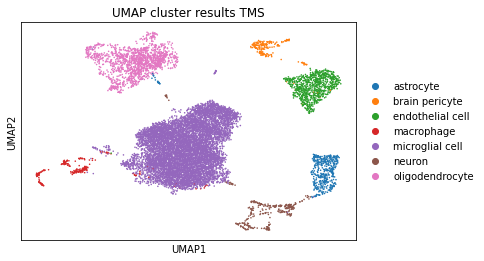

In [12]:
# For the TMS dataset

sc.pp.neighbors(brain_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(brain_data_overlap)
sc.pl.umap(brain_data_overlap, color = 'cell_ontology_class', title = 'UMAP cluster results TMS', save ='UMAP cluster results TMS cell type.png')


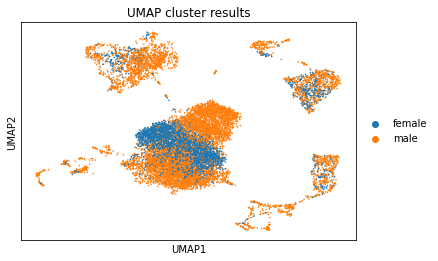

In [10]:
sc.pp.neighbors(brain_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(brain_data_overlap)
sc.pl.umap(brain_data_overlap, color = 'sex', title = 'UMAP cluster results', save = 'UMAP cluster results TMS gender.png')

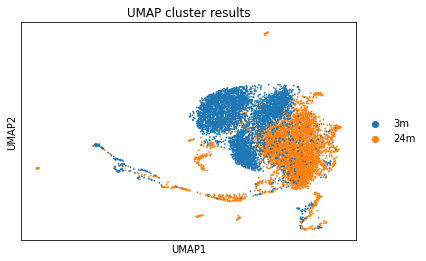

In [39]:
sc.pp.neighbors(brain_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(brain_data_overlap)
sc.pl.umap(brain_data_overlap, color = 'age', title = 'UMAP cluster results', save = 'UMAP cluster results TMS age.png')

         Falling back to preprocessing with `sc.pp.pca` and default params.


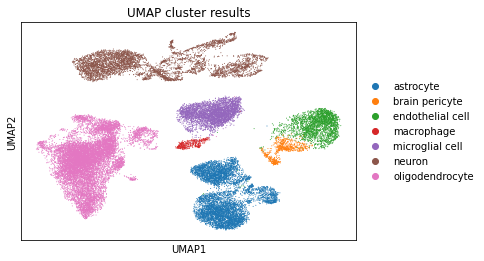

In [13]:
sc.pp.neighbors(rubin_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(rubin_data_overlap)
sc.pl.umap(rubin_data_overlap, color = 'cell_type', title = 'UMAP cluster results', save = 'UMAP cluster results Rubin cell type.png')

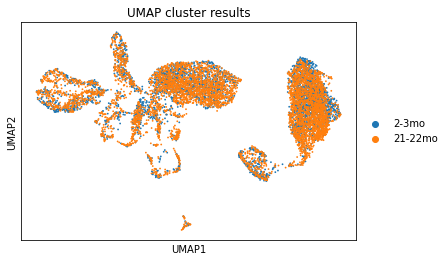

In [41]:
sc.tl.umap(rubin_data_overlap)
sc.pl.umap(rubin_data_overlap, color = 'all_cells_by_age', title = 'UMAP cluster results', save = 'UMAP cluster results Rubin age.png')

x - OPC: oligodendrocyte precursor cells <br>
match - OLG: oligodendrocytes <br>
x OEG: olfactory ensheathing glia <br>
x - NSC: neural stem cells <br>
x ARP: astrocyte-restricted precursors <br>
match - ASC: astrocytes <br>
x NRP: neuronal-restricted precursors <br>
x - ImmN: immature neurons <br>
match - mNEUR: mature neurons <br>
x NendC: neuroendocrine cells <br>
x EPC: ependymocytes <br>
x HypEPC: hypendymal cells <br>
x TNC: tanycytes <br>
x CPC: choroid plexus epithelial cells <br>
match - EC: endothelial cells <br>
match - PC: pericytes <br>
x VSMC: vascular smooth muscle cells <br>
x Hb-VC: hemoglobin-expressing vascular cells <br>
x VLMC: vascular and leptomeningeal cells <br>
x ABC: arachnoid barrier cells <br>
match - MG: microglia <br>
x MNC: monocytes <br>
match - MAC: macrophages <br>
x DC: dendritic cells <br>
x NEUT: neutrophils <br>

--> we have 7 cell types that match

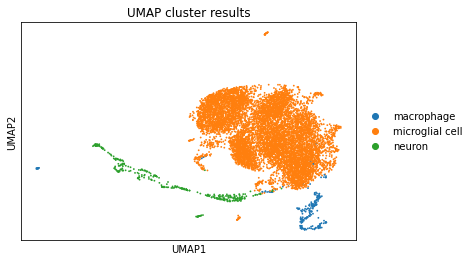

In [42]:
# For the TMS dataset - replotting only with the overlapping cells

sc.pp.neighbors(brain_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(brain_data_overlap)
sc.pl.umap(brain_data_overlap, color = 'cell_ontology_class', title = 'UMAP cluster results')

astrocyte


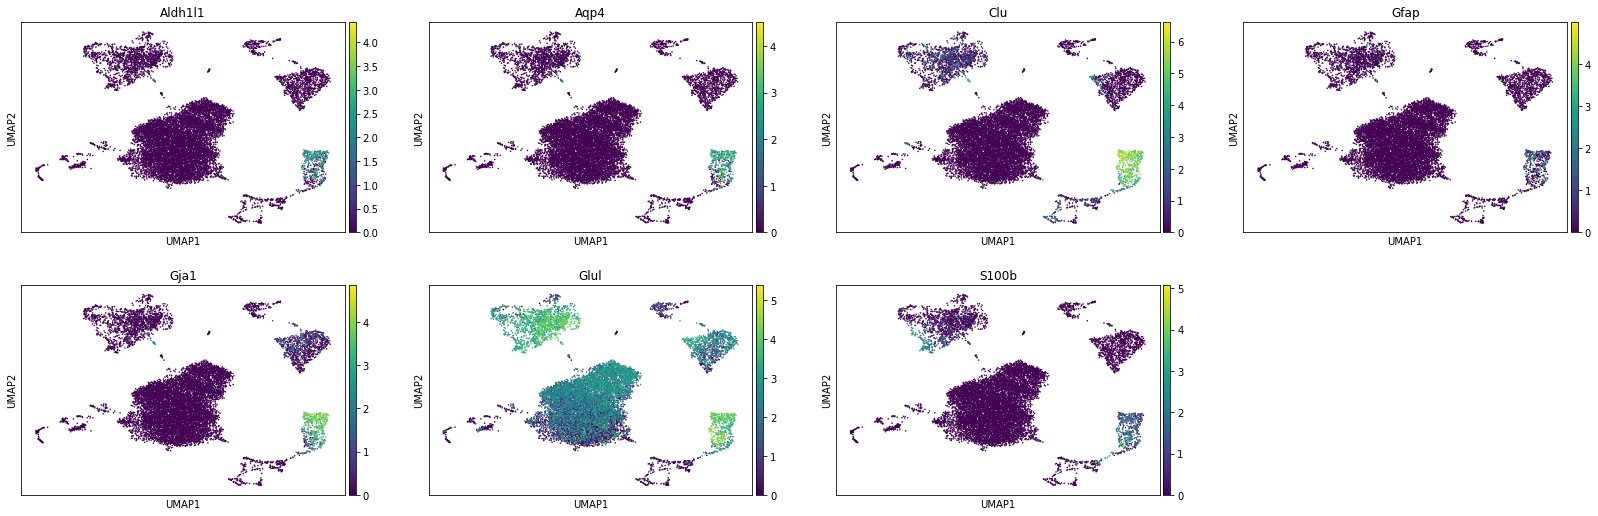

brain pericyte


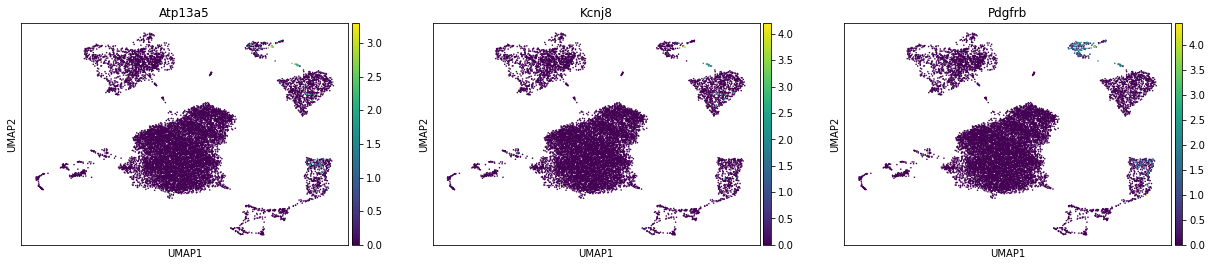

macrophage


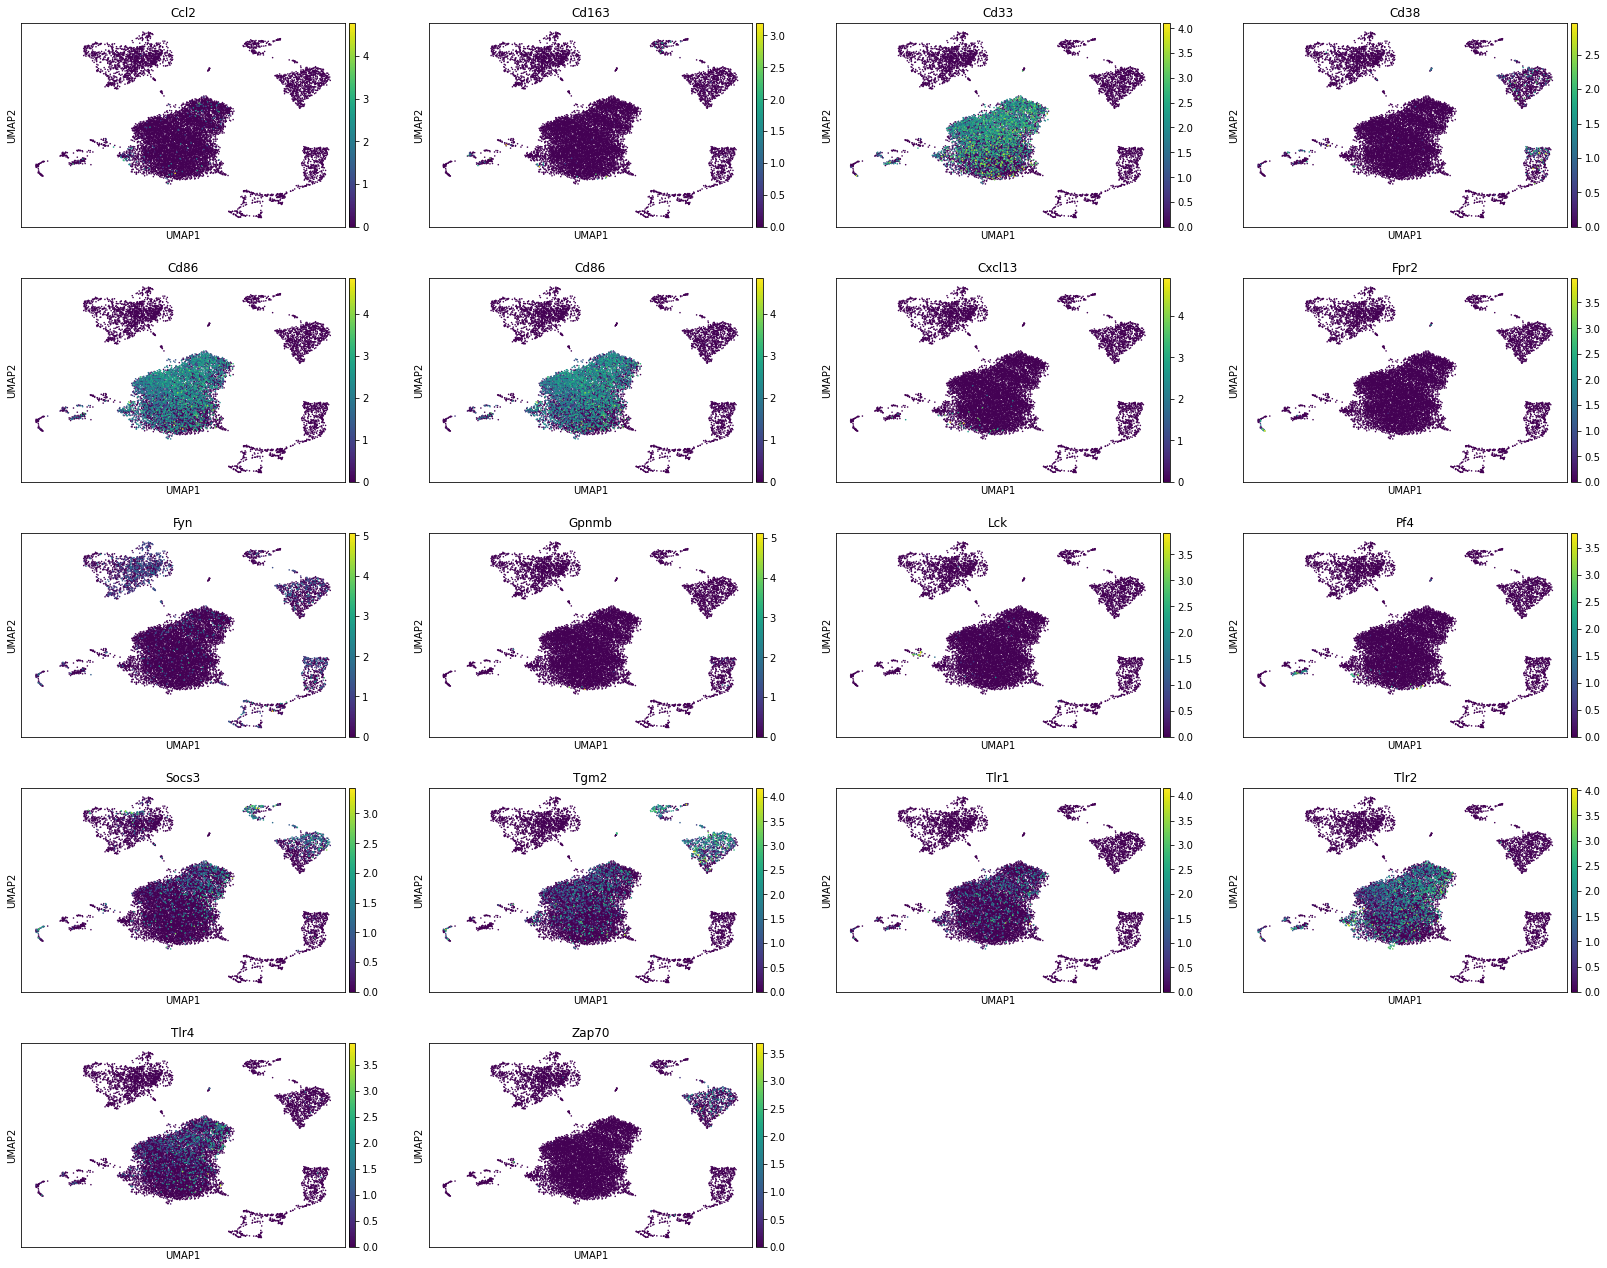

microglial cell


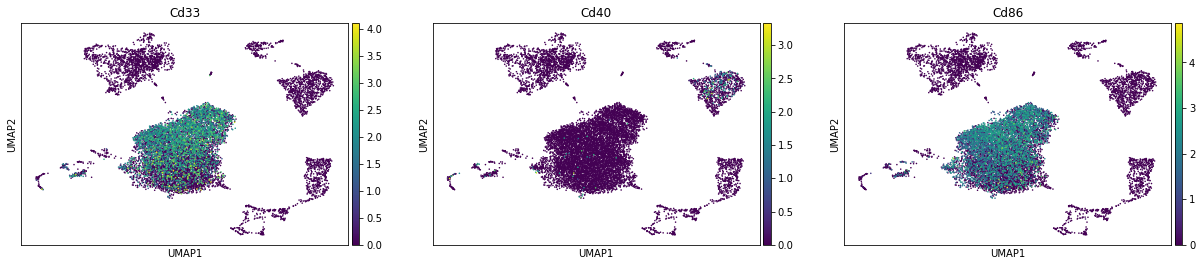

neuron


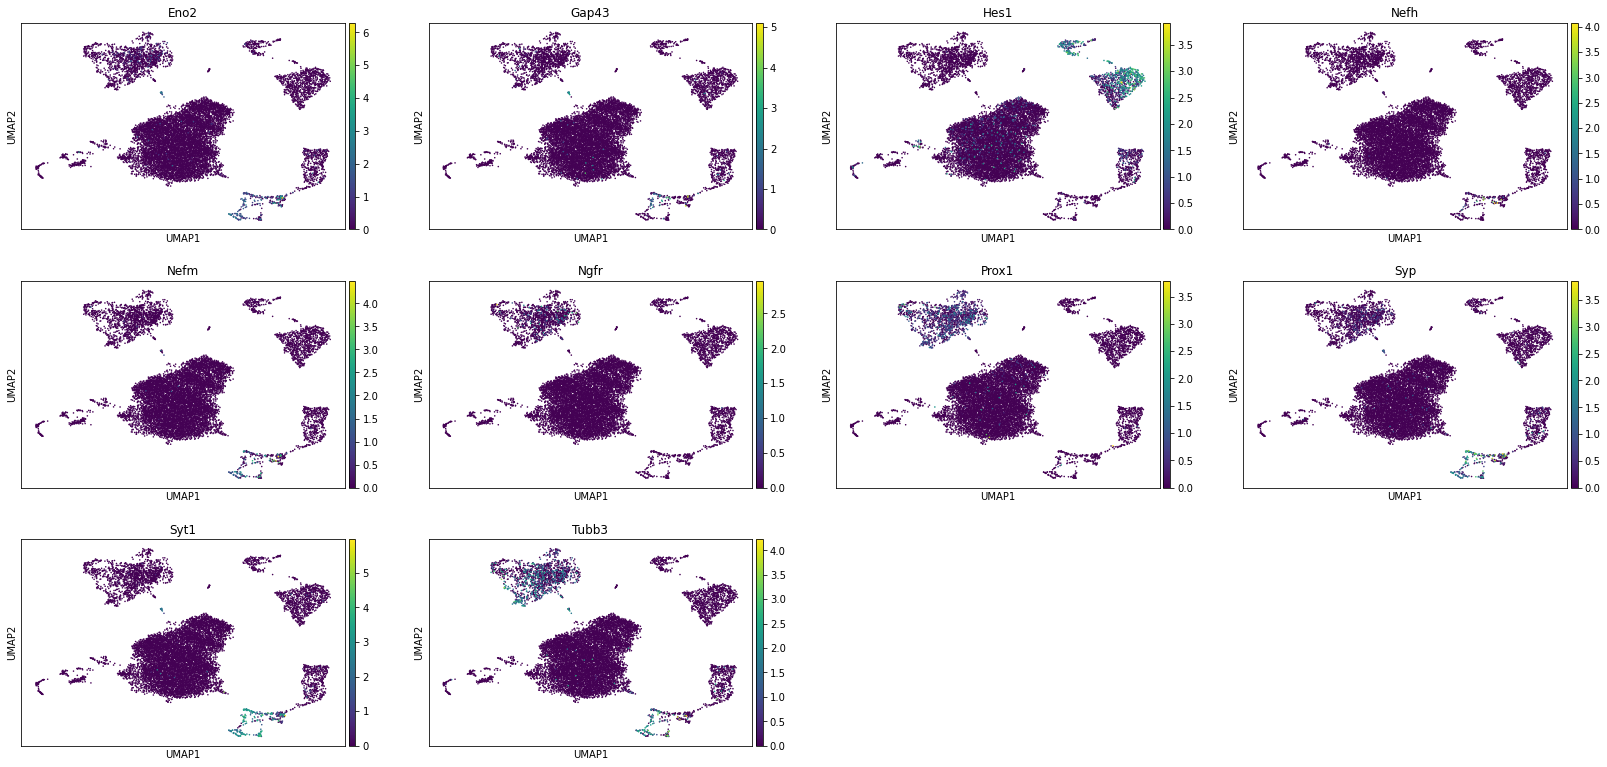

endothelial


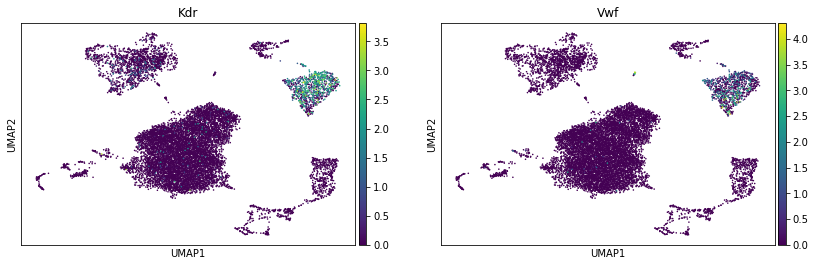

oligodendrocyte


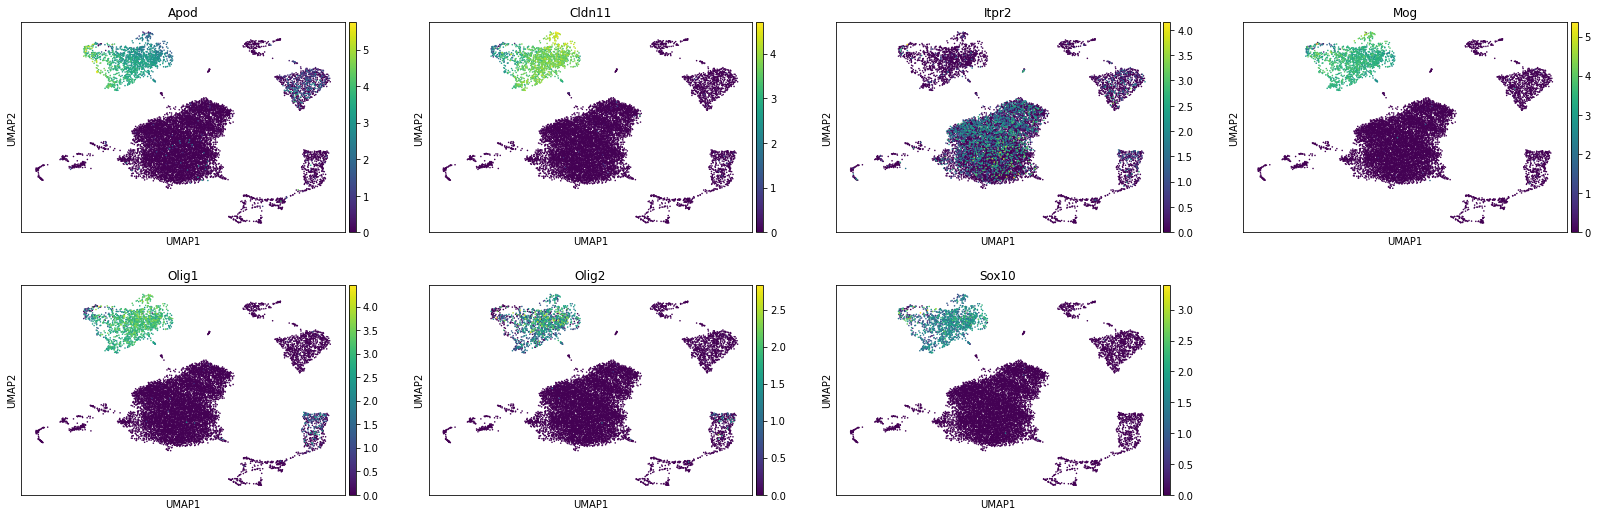

In [14]:
# For the TMS dataset - the cell markers that are used for each cell type

brain_data_gene_filtered = pd.DataFrame(brain_data_overlap.var_names)
brain_data_gene_filtered.rename(columns = {'index':'Gene'}, inplace = True)
for i in enumerate(cell_markers.columns):
    print(i[1])
    markers = pd.DataFrame(cell_markers[i[1]].dropna())
    markers = markers.rename(columns={i[1]: 'Gene'})
    markers_ = brain_data_gene_filtered.merge(markers, how = 'inner', on='Gene') # only keep the markers that are present in the filtered matrix of counts
    sc.pl.umap(brain_data_overlap, color = markers_['Gene'].tolist(), save = i[1] + ' UMAP for TMS.png')
    

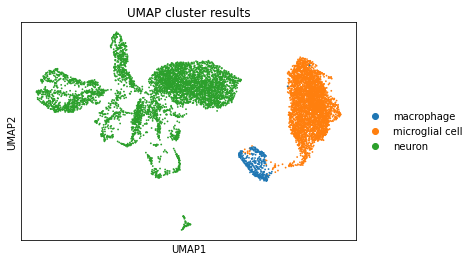

In [44]:
# For the Rubin dataset - replotting only with the overlapping cells

sc.pp.neighbors(rubin_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(rubin_data_overlap)
sc.pl.umap(rubin_data_overlap, color = 'cell_type', title = 'UMAP cluster results')

astrocyte


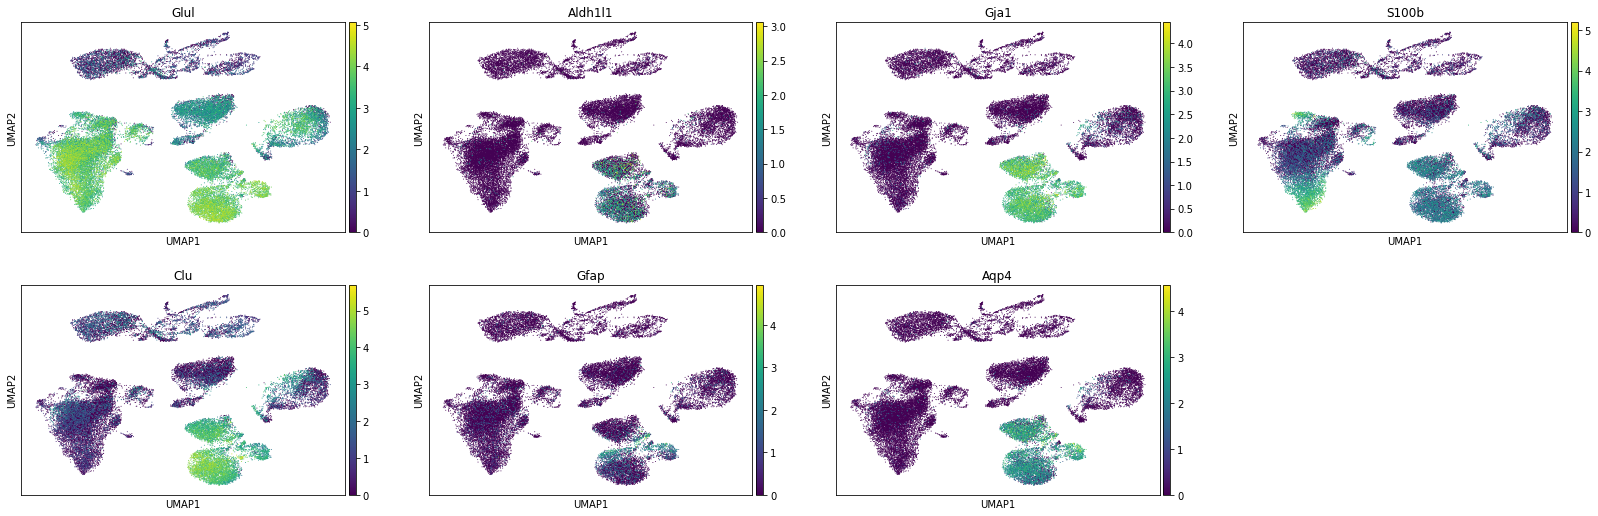

brain pericyte


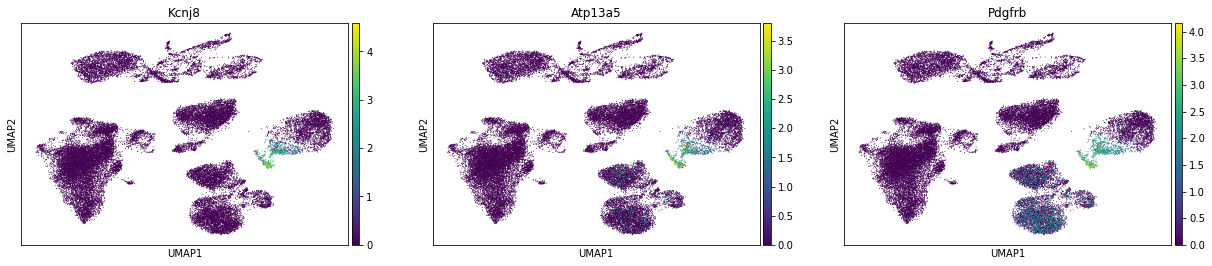

macrophage


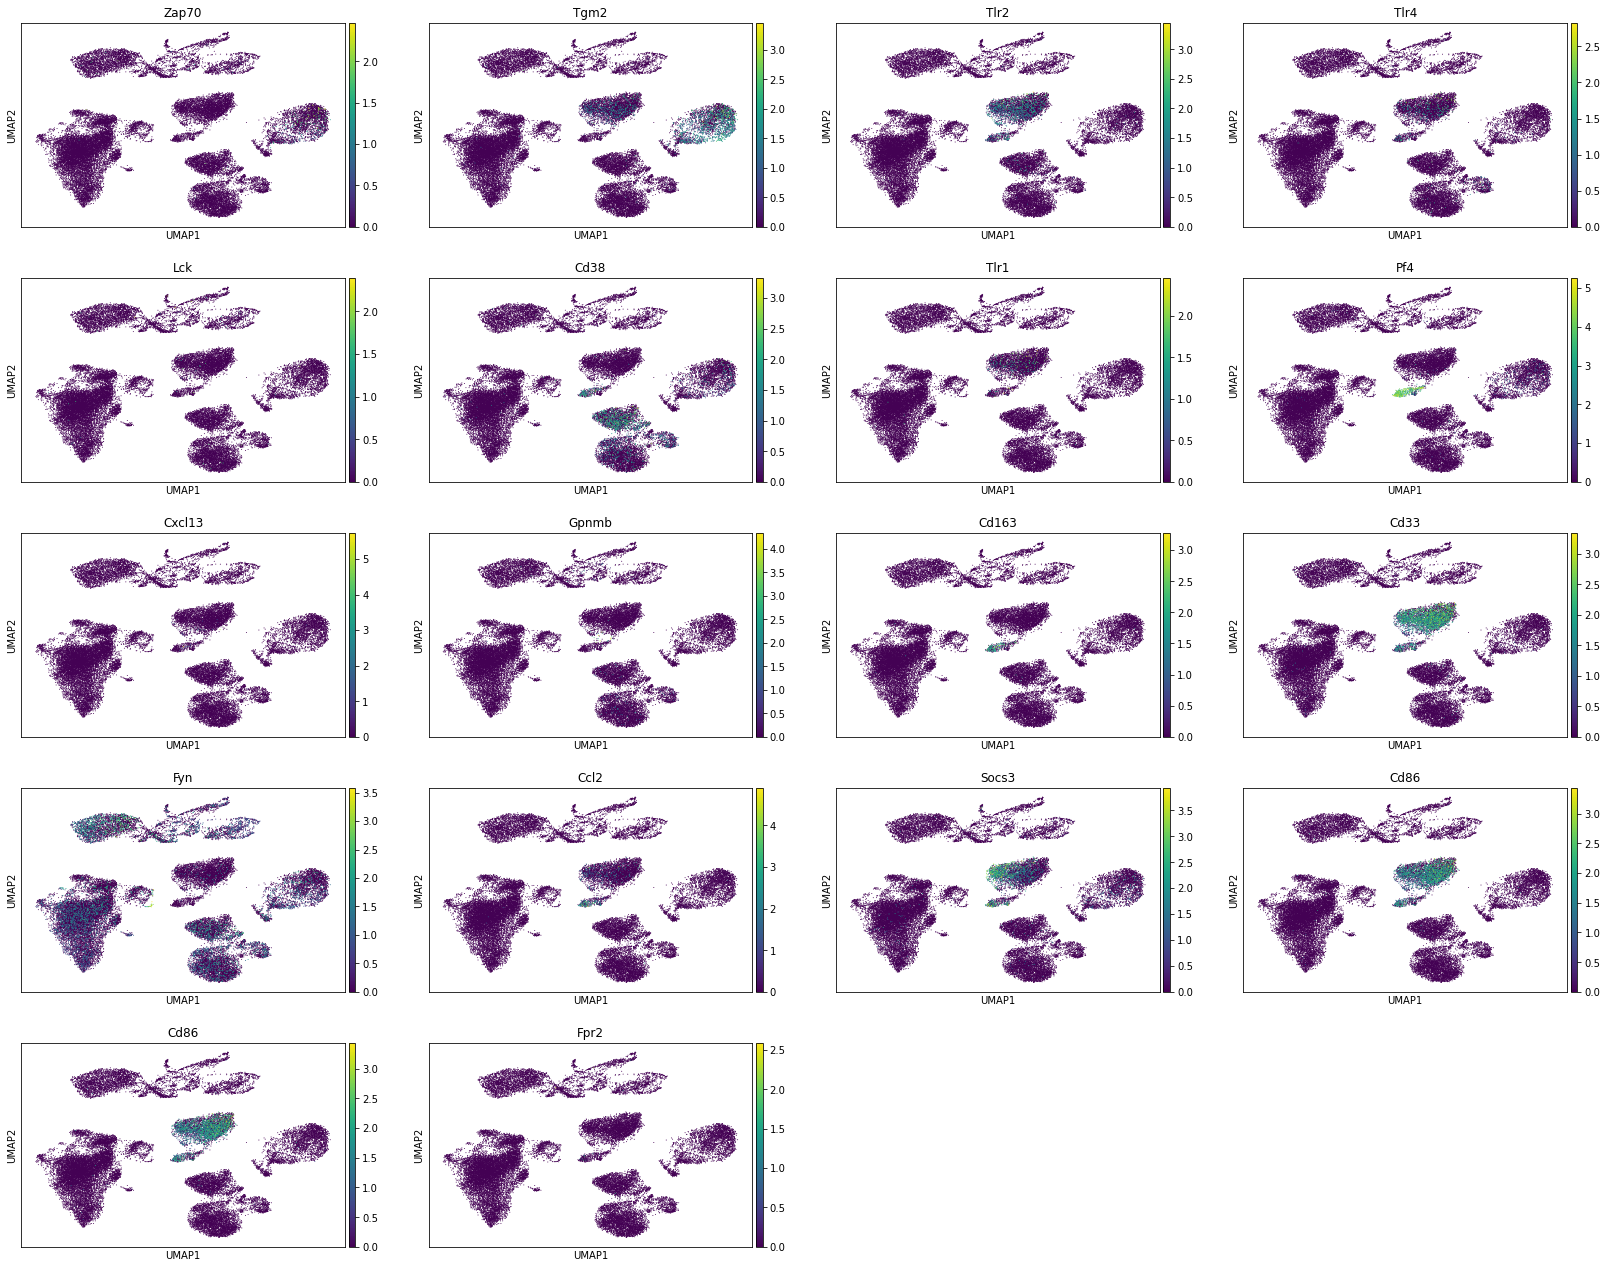

microglial cell


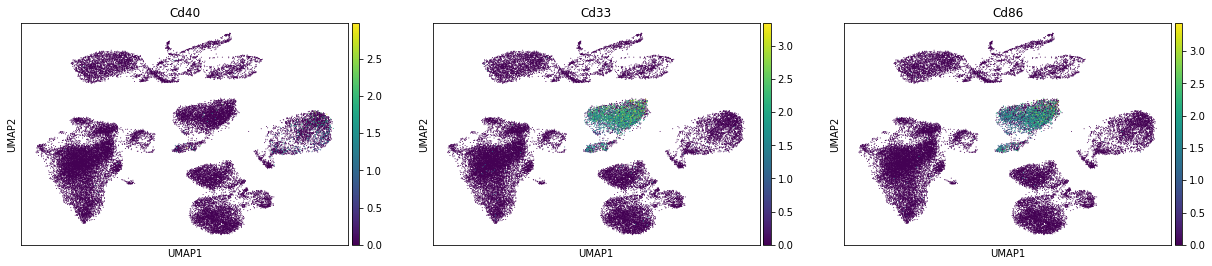

neuron


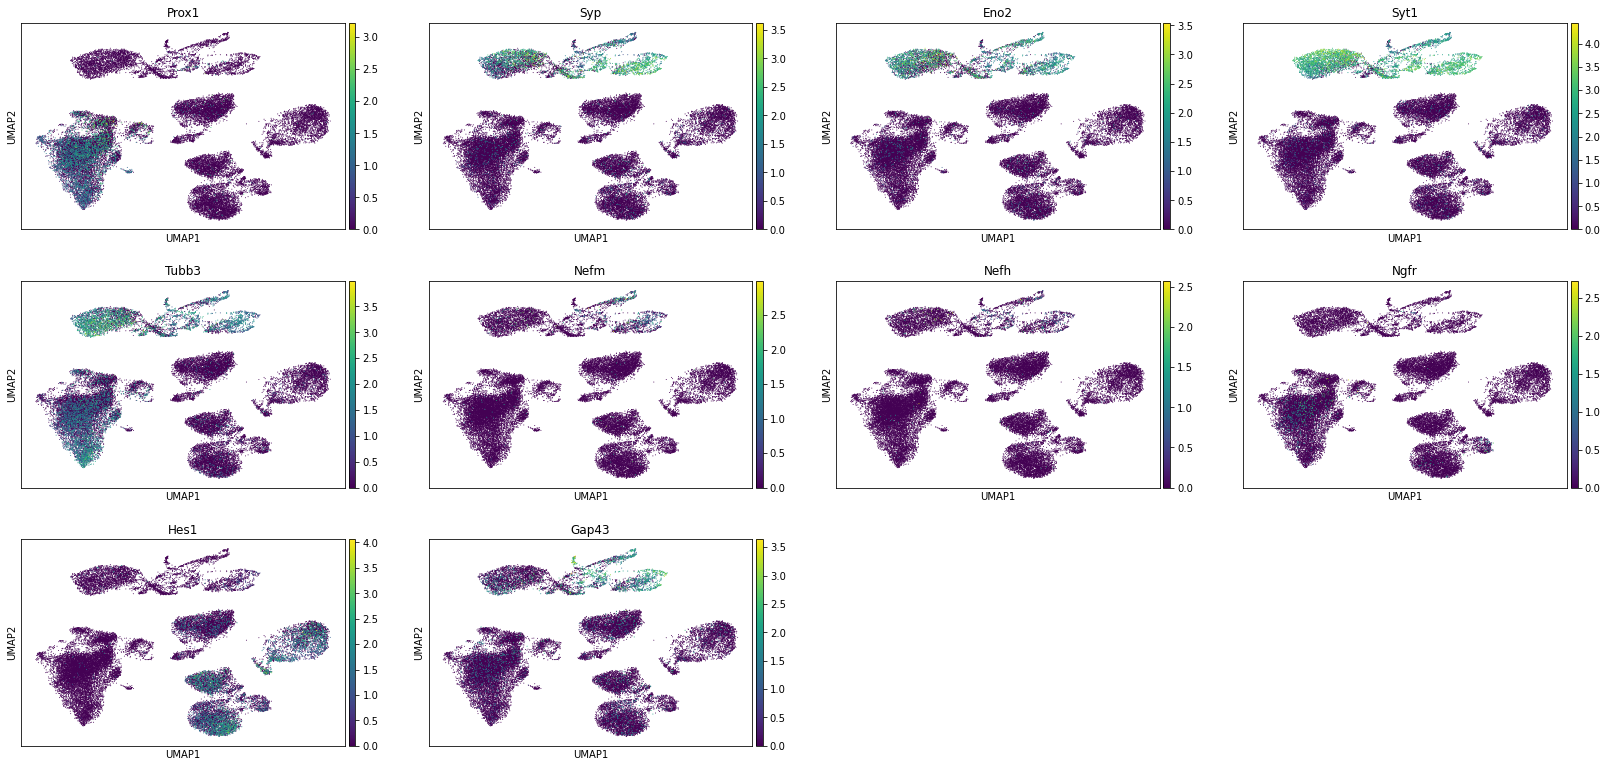

endothelial


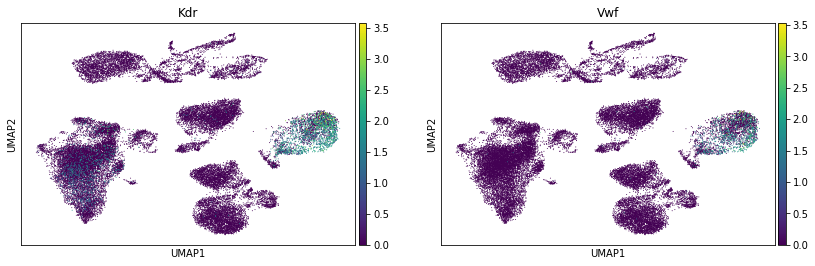

oligodendrocyte


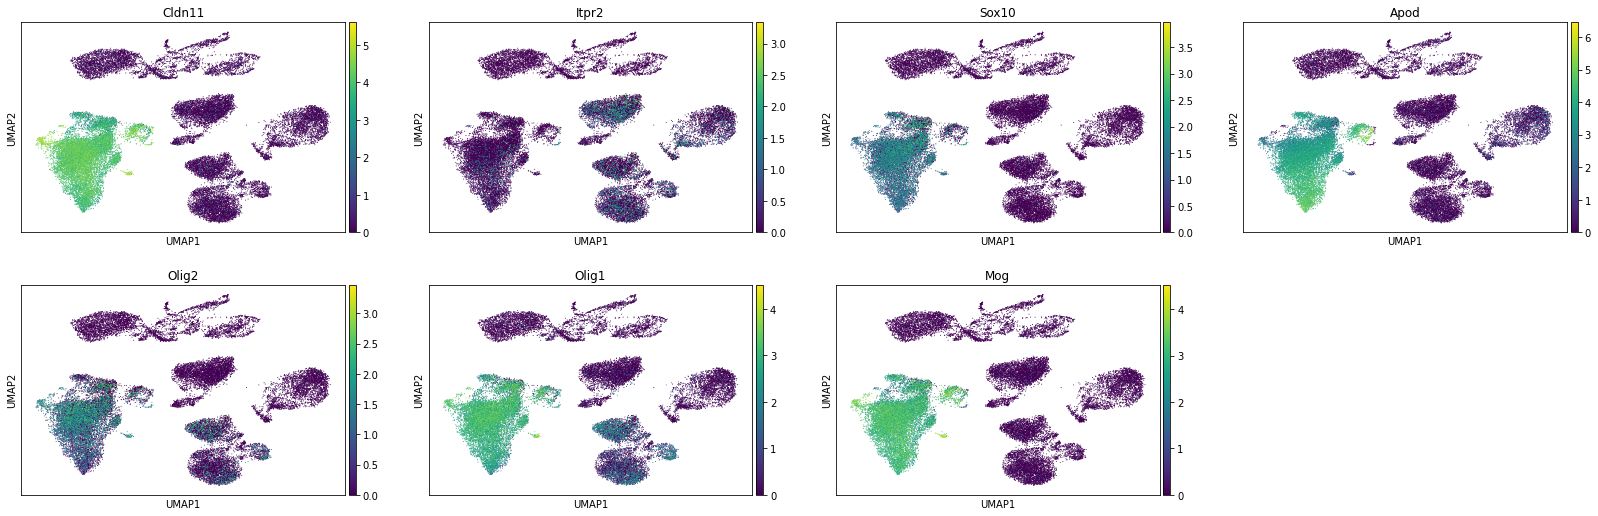

In [15]:
# For the Rubin dataset - the cell markers that are used for each cell type

rubin_data_gene_filtered = pd.DataFrame(rubin_data_overlap.var_names)
rubin_data_gene_filtered.rename(columns = {'gene':'Gene'}, inplace = True)
cell_markers_expressed = pd.DataFrame(columns = cell_markers.columns)
for i in enumerate(cell_markers.columns):
    print(i[1])
    markers = pd.DataFrame(cell_markers[i[1]].dropna())
    markers = markers.rename(columns={i[1]: 'Gene'})
    markers_ = rubin_data_gene_filtered.merge(markers, how = 'inner', on='Gene') # only keep the markers that are present in the filtered matrix of counts
    cell_markers_expressed[i[1]] = markers_
    sc.pl.umap(rubin_data_overlap, color = markers_['Gene'].tolist(), save = i[1] + ' UMAP for Rubin.png')

categories: astrocyte, brain pericyte, endothelial cell, etc.
var_group_labels: astrocyte, brain pericyte, macrophage, etc.


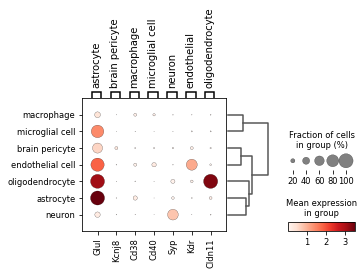

In [18]:
""" cell_markers_expressed.dropna(axis=0, how='any', inplace=True)
cell_markers_dict = cell_markers_expressed.to_dict(orient='list')
sc.pl.dotplot(brain_data_overlap, cell_markers_dict, 'cell_ontology_class', dendrogram=True) """

In [10]:
def plot_genes_tms(cl):
# sc.pp.filter_genes(cl, min_cells=0.1*(counts.n_vars)) 
# we want to get rid of anything with low abundance or low variance: just remove the bottom 10% of out genes since this is a single cell type
    sc.tl.rank_genes_groups(cl, groupby = 'age', method='wilcoxon', key= 'wilcoxon')
    sc.pl.rank_genes_groups(cl, n_genes=10, sharey=False, values_to_plot = 'logfoldchanges')
    sc.pl.rank_genes_groups_violin(cl, n_genes=10, groups = ['3m','24m'], save = 'TMS bulk violin plot.png')
    sc.pl.rank_genes_groups_dotplot(cl, n_genes=10, values_to_plot = 'logfoldchanges', save = 'TMS bulk dot plot.png', cmap='bwr')
    return 


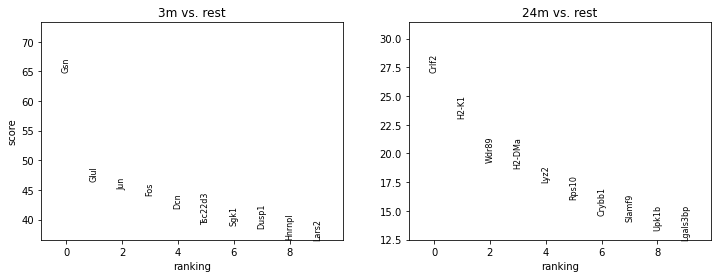

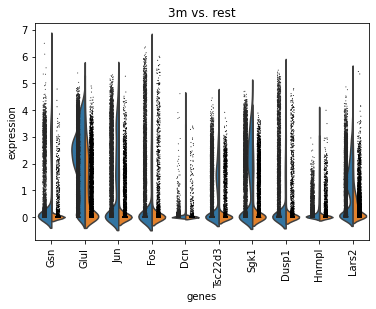

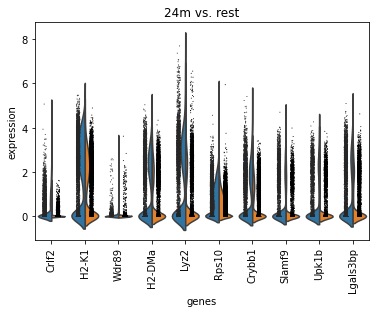

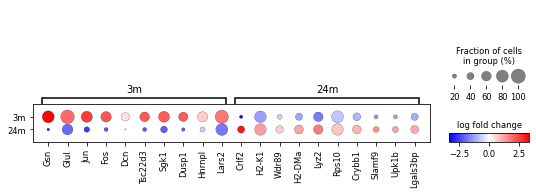

In [11]:
plot_genes_tms(brain_data_overlap)

<b>Top hits DEGs for the Tabula Muris Senis dataset: </b>

<u>Downregulated: Gsn, Glul, Jun, Fos, Dcn, Tsc22d3, Sgk1, Dusp1, Hnrnpl, Lars2 </u>

Gsn - The protein encoded by this gene binds to the "plus" ends of actin monomers and filaments to prevent monomer exchange. The encoded calcium-regulated protein functions in both assembly and disassembly of actin filaments. (shown to be involvement in AD - can help reduce amyloid burden) https://www.nature.com/articles/emm201376

Glul - The protein encoded by this gene belongs to the glutamine synthetase family. It catalyzes the synthesis of glutamine from glutamate and ammonia in an ATP-dependent reaction. This protein plays a role in ammonia and glutamate detoxification, acid-base homeostasis, cell signaling, and cell proliferation. 

Jun - c-Jun is a protein that in humans is encoded by the JUN gene. c-Jun, in combination with c-Fos, forms the AP-1 early response transcription factor.

Fos - c-Jun, in combination with c-Fos, forms the AP-1 early response transcription factor.

Dcn - This protein plays a role in collagen fibril assembly. sStromal-associated genes, was found to be differentially expressed in the tabula muris senis paper. 

Tsc22d3 - This gene encodes the anti-inflammatory protein glucocorticoid (GC)-induced leucine zipper. Expression of this gene stimulated by glucocorticoids and interleukin 10 and it appears to play a key role in the anti-inflammatory and immunosuppressive effects of this steroid. 

Sgk1 - This gene encodes a serine/threonine protein kinase that plays an important role in cellular stress response.

Dusp1 - The protein encoded by this gene is a phosphatase with dual specificity for tyrosine and threonine. The encoded protein can dephosphorylate MAP kinase MAPK1/ERK2, which results in its involvement in several cellular processes.

Hnrnpl - Heterogeneous nuclear RNAs (hnRNAs) which include mRNA precursors and mature mRNAs are associated with specific proteins to form heterogenous ribonucleoprotein (hnRNP) complexes. Heterogeneous nuclear ribonucleoprotein L is among the proteins that are stably associated with hnRNP complexes and along with other hnRNP proteins is likely to play a major role in the formation, packaging, processing, and function of mRNA.

Lars2 - This gene encodes a class 2 aminoacyl-tRNA synthetase, mitochondrial leucyl-tRNA synthetase

<u>Upregulated: Crlf2, H2-K1, Wdr89, H2-DMa, Lyz2, Rps10, Crybb1, Slamf9, Upk1b, Lgals3bp </u>

Crlf2 - This gene encodes a member of the type I cytokine receptor family. 

H2-K1 - Enables MHC class I protein binding activity and peptide antigen binding activity. 

Wdr89 - WD Repeat-Containing Protein 89

H2-DMa - Plays a critical role in catalyzing the release of class II-associated invariant chain peptide (CLIP) from newly synthesized MHC class II molecules and freeing the peptide binding site for acquisition of antigenic peptides.

Lyz2 - Enables lysozyme activity. Involved in defense response to Gram-negative bacterium and defense response to Gram-positive bacterium.

Rps10 - Small Ribosomal Subunit Protein ES10.

Crybb1 - Crystallin Beta B1, Eye Lens Structural Protein

Slamf9 - This gene encodes a member of the signaling lymphocytic activation molecule family.

Upk1b - The protein encoded by this gene is a member of the transmembrane 4 superfamily, also known as the tetraspanin family. Most of these members are cell-surface proteins that are characterized by the presence of four hydrophobic domains. The proteins mediate signal transduction events that play a role in the regulation of cell development, activation, growth and motility.

Lgals3bp - The galectins are a family of beta-galactoside-binding proteins implicated in modulating cell-cell and cell-matrix interactions. LGALS3BP has been found elevated in the serum of patients with cancer and in those infected by the human immunodeficiency virus (HIV).

In [12]:
def plot_genes_rubin(cl):
# sc.pp.filter_genes(cl, min_cells=0.1*(counts.n_vars)) 
# we want to get rid of anything with low abundance or low variance: just remove the bottom 10% of out genes since this is a single cell type
    sc.pl.rank_genes_groups(cl, n_genes=10, sharey=False, values_to_plot = 'logfoldchanges')
    sc.pl.rank_genes_groups_violin(cl, n_genes=10, save = 'Lee Rubin bulk violin plot.png')
    sc.pl.rank_genes_groups_dotplot(cl, n_genes=10, values_to_plot = 'logfoldchanges', save = 'Lee Rubin bulk dot plot.png', cmap='bwr')
    return cl


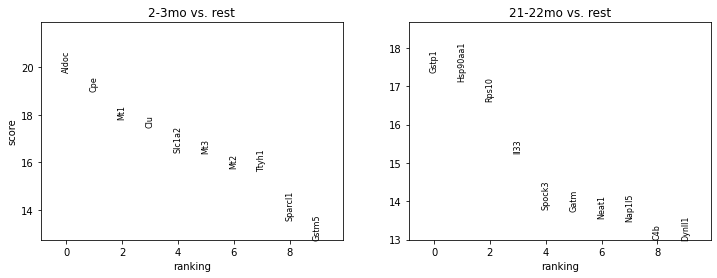

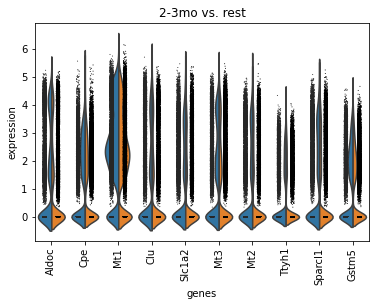

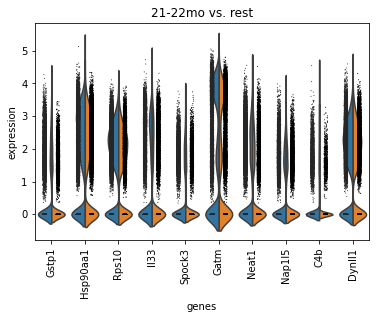

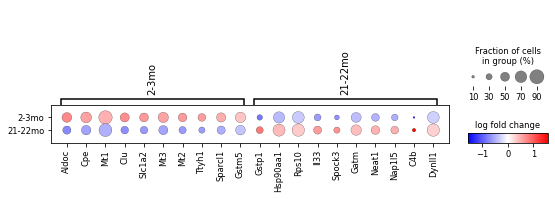

AnnData object with n_obs × n_vars = 31701 × 7952
    obs: 'cell', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'mouse.id'
    var: 'gene'
    uns: 'rank_genes_groups'

In [14]:
sc.tl.rank_genes_groups(rubin_data_overlap, groupby = 'all_cells_by_age', method='wilcoxon', key= 'wilcoxon')
plot_genes_rubin(rubin_data_overlap)

# Genes were considered differentially expressed if they had an absolute log-fold change > 0.2 with adjusted p-value < 0.001


<b> Top hits DEGs for the Rubin dataset: </b>

<u> Downregulated: Aldoc, Cpe, Mt1, Clu, Slc1a2, Mt3, Mt2, Ttyh1, Sparcl1, Gstm5 </u>

Aldoc: This gene encodes a member of the class I fructose-biphosphate aldolase gene family. Expressed specifically in the hippocampus and Purkinje cells of the brain.

Cpe: This gene encodes a member of the M14 family of metallocarboxypeptidases. The encoded preproprotein is proteolytically processed to generate the mature peptidase. This peripheral membrane protein cleaves C-terminal amino acid residues and is involved in the biosynthesis of peptide hormones and neurotransmitters, including insulin.

Mt1: This gene is a member of the metallothionein family of genes. Proteins encoded by this gene family are low in molecular weight, are cysteine-rich, lack aromatic residues, and bind divalent heavy metal ions. The conserved cysteine residues co-ordinate metal ions using mercaptide linkages. These proteins act as anti-oxidants, protect against hydroxyl free radicals, are important in homeostatic control of metal in the cell, and play a role in detoxification of heavy metals.
    
Clu: The protein encoded by this gene is a secreted chaperone that can under some stress conditions also be found in the cell cytosol. It has been suggested to be involved in several basic biological events such as cell death, tumor progression, and neurodegenerative disorders.

Slc1a2: This gene encodes a member of a family of solute transporter proteins. The membrane-bound protein is the principal transporter that clears the excitatory neurotransmitter glutamate from the extracellular space at synapses in the central nervous system.

Mt3: This gene is a member of the metallothionein family of genes. Proteins encoded by this gene family are low in molecular weight, are cysteine-rich, lack aromatic residues, and bind divalent heavy metal ions. 
    
Mt2: This gene is a member of the metallothionein family of genes. 
    
Ttyh1: This gene encodes a member of the tweety family of proteins. Members of this family function as chloride anion channels. 

Sparcl1: Predicted to enable calcium ion binding activity; collagen binding activity; and extracellular matrix binding activity.
    
Gstm5: The mu class of enzymes functions in the detoxification of electrophilic compounds, including carcinogens, therapeutic drugs, environmental toxins and products of oxidative stress, by conjugation with glutathione.
    
<u> Upregulated: Gstp1, Hsp90aa1, Rps10, I22, Spock2, Gatm, Neat1, Nap1l5, C4b, Dynll1 </u>
    
Gstp1: Glutathione S-transferases (GSTs) are a family of enzymes that play an important role in detoxification by catalyzing the conjugation of many hydrophobic and electrophilic compounds with reduced glutathione. 

Hsp90aa1: The protein encoded by this gene is an inducible molecular chaperone that functions as a homodimer. The encoded protein aids in the proper folding of specific target proteins by use of an ATPase activity that is modulated by co-chaperones.

Rps10: Small Ribosomal Subunit Protein ES10.
    
I22: This gene encodes a member of the WD repeat protein family. WD repeats are minimally conserved regions of approximately 40 amino acids typically bracketed by gly-his and trp-asp (GH-WD), which may facilitate formation of heterotrimeric or multiprotein complexes. Members of this family are involved in a variety of cellular processes, including cell cycle progression, signal transduction, apoptosis, and gene regulation.
    
Spock2: This gene encodes a protein which binds with glycosaminoglycans to form part of the extracellular matrix.
    
Gatm: This enzyme participates in the two-step production (synthesis) of the compound creatine from the protein building blocks (amino acids) glycine, arginine, and methionine. 

Neat1: This gene produces a long non-coding RNA (lncRNA) transcribed from the multiple endocrine neoplasia locus. 

Nap1l5: This gene encodes a protein that shares sequence similarity to nucleosome assembly factors, but may be localized to the cytoplasm rather than the nucleus. 
    
C4b: This gene encodes the basic form of complement factor 4, and together with the C4A gene, is part of the classical activation pathway. The protein is expressed as a single chain precursor which is proteolytically cleaved into a trimer of alpha, beta, and gamma chains prior to secretion. 
    
Dynll1: Cytoplasmic dyneins are large enzyme complexes with a molecular mass of about 1,200 kD. They contain two force-producing heads formed primarily from dynein heavy chains, and stalks linking the heads to a basal domain, which contains a varying number of accessory intermediate chains.

In [186]:
upregulated_rubin = lee_rubin_mouse[:, (lee_rubin_mouse.uns['rank_genes_groups']['logfoldchanges']['21-22mo'] > 0.2)]
downregulated_rubin = lee_rubin_mouse[:, (lee_rubin_mouse.uns['rank_genes_groups']['logfoldchanges']['21-22mo'] < -0.2)]


In [187]:
from matplotlib_venn import venn2

In [188]:
upregulated_tms = tabula_muris_mouse[:, (tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m'] > 0.2)]
downregulated_tms = tabula_muris_mouse[:, (tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m'] < -0.2)]


In [189]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [190]:
# finding the intersection of the upregulated/downregulated genes
upregulated_rubin = upregulated_rubin.var_names.tolist()
downregulated_rubin = downregulated_rubin.var_names.tolist()
print('upregulated_rubin ', len(upregulated_rubin))
print('downregulated_rubin ', len(downregulated_rubin))

upregulated_tms = upregulated_tms.var_names.tolist()
downregulated_tms = downregulated_tms.var_names.tolist()
print('upregulated_tms ', len(upregulated_tms))
print('downregulated_tms ', len(downregulated_tms))

down_intersection = intersection(downregulated_rubin, downregulated_tms)
up_intersection = intersection(upregulated_rubin, upregulated_tms)
print('up_intersection ', len(up_intersection))
print('down_intersection ', len(down_intersection))

upregulated_rubin  2168
downregulated_rubin  924
upregulated_tms  561
downregulated_tms  6532
up_intersection  147
down_intersection  784


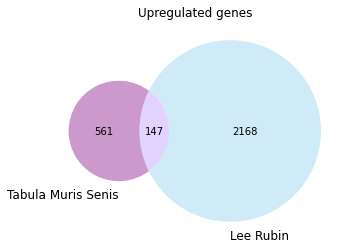

In [232]:
venn2(subsets = (len(upregulated_tms), len(upregulated_rubin), len(up_intersection)), set_labels = ('Tabula Muris Senis', 'Lee Rubin'), set_colors=('purple', 'skyblue'))
plt.title('Upregulated genes')
plt.savefig("figures/upregulated_genes_bulk_3cell")
plt.show()


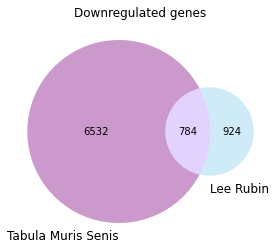

In [233]:
venn2(subsets = (len(downregulated_tms), len(downregulated_rubin), len(down_intersection)), set_labels = ('Tabula Muris Senis', 'Lee Rubin'), set_colors=('purple', 'skyblue'))
plt.title('Downregulated genes')
plt.savefig("figures/downregulated_genes_bulk_3cell")
plt.show()


In [95]:
brain_data_overlap_inter

View of AnnData object with n_obs × n_vars = 9291 × 61
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'cell_ontology_class_colors', 'age_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [234]:
# Defining the genes that will be used for the training of the RF classifier: the genes that are either logfoldchange that is greater/less than 0.2 or -0.2. 
# The inter training set adds that the genes have to be intersecting with the Rubin dataset as differentially expressed.

# brain_data_overlap_diffex = brain_data_overlap[:, (brain_data_overlap.uns['rank_genes_groups']['logfoldchanges']['24m'] > 0.2)|(brain_data_overlap.uns['rank_genes_groups']['logfoldchanges']['24m'] < -0.2)]
# brain_data_overlap_diffex = brain_data_overlap[:, np.argsort(np.abs(tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m']))[-500:]]
# intersection = up_intersection + down_intersection
# brain_data_overlap_inter = brain_data_overlap_diffex[:, brain_data_overlap_diffex.var_names.isin(intersection)]

# Sort the abs of logfoldchange
genes_train_TM = tabula_muris_mouse.uns['rank_genes_groups']['names']['24m'][np.argsort(-np.abs(tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m']))][:500]
genes_train_TM_logfold = tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m'][np.argsort(-np.abs(tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m']))][:500]
brain_data_overlap_diffex = brain_data_overlap[:, brain_data_overlap.var_names.isin(genes_train_TM)]
rubin_data_overlap_diffex = rubin_data_overlap[:, rubin_data_overlap.var_names.isin(genes_train_TM)]


In [235]:
# intersection

# rubin_data_overlap_diffex = rubin_data_overlap[:, (brain_data_overlap.uns['rank_genes_groups']['logfoldchanges']['24m'] > 0.2)|(brain_data_overlap.uns['rank_genes_groups']['logfoldchanges']['24m'] < -0.2)]
# rubin_data_overlap_diffex = rubin_data_overlap[:, rubin_data_overlap.var_names.isin(brain_data_overlap_diffex.var_names)]

indxs = []

for gene in tabula_muris_mouse.uns['rank_genes_groups']['names']['24m']:
    indxs.append(np.where(gene == lee_rubin_mouse.uns['rank_genes_groups']['names']['21-22mo'])[0][0])

genes_train_Inter = tabula_muris_mouse.uns['rank_genes_groups']['names']['24m'][np.argsort(-np.abs(np.mean([tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m'], lee_rubin_mouse.uns['rank_genes_groups']['logfoldchanges']['21-22mo'][indxs]], axis = 0)))][:500]
genes_train_Inter_logfold = tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m'][np.argsort(-np.abs(np.mean([tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m'], lee_rubin_mouse.uns['rank_genes_groups']['logfoldchanges']['21-22mo'][indxs]], axis = 0)))][:500]
brain_data_overlap_inter = brain_data_overlap[:, brain_data_overlap.var_names.isin(genes_train_Inter)]
rubin_data_overlap_inter = rubin_data_overlap[:, rubin_data_overlap.var_names.isin(genes_train_Inter)]


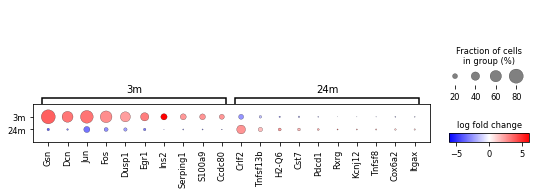

In [376]:
inter_reg = tabula_muris_mouse.uns['rank_genes_groups']['names']['24m'][np.argsort(-np.abs(np.mean([tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m'], lee_rubin_mouse.uns['rank_genes_groups']['logfoldchanges']['21-22mo'][indxs]], axis = 0)))][:500]
inter_reg = brain_data_overlap[:, brain_data_overlap.var_names.isin(inter_reg)]
inter_reg.raw = inter_reg
sc.tl.rank_genes_groups(inter_reg, groupby = 'age', method='wilcoxon', key= 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(inter_reg, n_genes=10, values_to_plot = 'logfoldchanges', save = 'inter_reg.png', cmap='bwr')


### Training a classifier

#### classifier trained on TMS upregulated/downreguated genes with 0.2 logfoldchange threshold

In [236]:
from sklearn.ensemble import RandomForestClassifier

brain_data_overlap_diffex_pd = pd.DataFrame(brain_data_overlap_diffex.X.toarray(), columns = brain_data_overlap_diffex.var.index.tolist(), index = brain_data_overlap_diffex.obs.cell.tolist())
brain_age_label_diffex_pd = brain_data_overlap_diffex.obs.age
brain_data_overlap_diffex_pd = brain_data_overlap_diffex_pd.sort_index(axis=1)

rubin_data_overlap_diffex_pd = pd.DataFrame(rubin_data_overlap_diffex.X.toarray(), columns = rubin_data_overlap_diffex.var.index.tolist(), index = rubin_data_overlap_diffex.obs.cell.tolist())
rubin_age_label_diffex_pd = rubin_data_overlap_diffex.obs.all_cells_by_age
rubin_data_overlap_diffex_pd = rubin_data_overlap_diffex_pd.sort_index(axis=1)

X_train, X_test, y_train, y_test = train_test_split(brain_data_overlap_diffex_pd, brain_age_label_diffex_pd, test_size=0.3, random_state=42)
X_rubin_test = rubin_data_overlap_diffex_pd
y_rubin_test = rubin_age_label_diffex_pd
y_rubin_test = y_rubin_test.replace({'2-3mo':'3m', '21-22mo':'24m'})

clf = RandomForestClassifier(max_depth = 15, random_state=0)
clf.fit(X_train, y_train)

impfeatures = pd.DataFrame(clf.feature_importances_, columns = ['Importance'], index = X_train.columns.tolist()) 
impfeatures.sort_values(by='Importance', ascending=False, inplace=True)
impfeatures.head(10)


Importance
Gsn         0.177470
Dcn         0.129329
Fos         0.084062
Plp1        0.074440
Ins2        0.055183
Jun         0.053735
Egr1        0.042483
Serping1    0.028969
Col3a1      0.023148
Fbln1       0.022582

In [ ]:
print("Best parameters found in the grid search: ", clf_grid.best_params_, "\n")
print("Not nested test score: ", clf_grid.best_score_, "\n") # Mean cross-validated score of the best_estimator
print("Nested CV test score: ", mean(cross_val_score(clf_grid, X_test, y_test))) # test score from a 5-fold CV

In [259]:
impfeatures = pd.DataFrame(clf.feature_importances_, columns = ['Importance'], index = X_train.columns.tolist()) 
impfeatures.sort_values(by='Importance', ascending=False, inplace=True)
impfeatures10 = impfeatures.head(10)

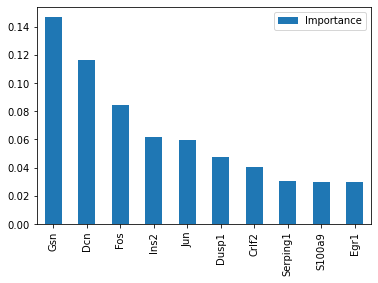

In [251]:
# visualizing the importance of the different features

impfeatures10.plot.bar()
plt.savefig('figures/res_10_TMStrain')

In [239]:
from sklearn.model_selection import cross_val_score

cv_score_train = cross_val_score(clf, X_train, y_train)
cv_score_test = cross_val_score(clf, X_test, y_test)
cv_score_test_rubin = cross_val_score(clf, X_rubin_test, y_rubin_test)

print('training score TMS: ', cv_score_train)
print('testing score TMS: ', cv_score_test)
print('testing score Rubin: ', cv_score_test_rubin)

training score TMS:  [0.94388932 0.95618755 0.95465027 0.96       0.94230769]
testing score TMS:  [0.94444444 0.92293907 0.94623656 0.93895871 0.96768402]
testing score Rubin:  [0.56657825 0.59151194 0.56687898 0.58545648 0.59660297]


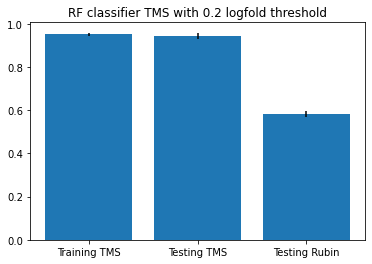

In [249]:
score_plot = pd.DataFrame(index = ['Training TMS', 'Testing TMS', 'Testing Rubin'], columns=['Score'])
score_plot['Score'] = [np.mean(cv_score_train), np.mean(cv_score_test), np.mean(cv_score_test_rubin)]
    
plt.bar(np.arange(len(score_plot['Score'])), score_plot['Score'], yerr = [np.std(cv_score_train), np.std(cv_score_test), np.std(cv_score_test_rubin)])
plt.xticks(np.arange(len(score_plot['Score'])), score_plot.index)
plt.title('RF classifier TMS with 0.2 logfold threshold')
plt.savefig('figures/RF classifier TMS')

In [260]:
from sklearn.metrics import confusion_matrix

y_pred_test_TMS = clf.predict(X_test)
y_pred_test_rubin = clf.predict(X_rubin_test)

matrix_TMS = confusion_matrix(y_test.to_numpy(), y_pred_test_TMS, labels=['3m', '24m'])
res_TMS = matrix_TMS.diagonal()/matrix_TMS.sum(axis=1)
print('matrix_TMS: ', res_TMS)

matrix_rubin = confusion_matrix(y_rubin_test.to_numpy(), y_pred_test_rubin, labels=['3m', '24m'])
res = matrix_rubin.diagonal()/matrix_rubin.sum(axis=1)
print('matrix_rubin: ', res)


matrix_TMS:  [0.95262391 0.94350282]
matrix_rubin:  [0.13996411 0.84586126]


In [245]:
matrix_TMS

array([[1307,   65],
       [  80, 1336]])

In [246]:
matrix_rubin

array([[ 546, 3355],
       [ 851, 4670]])

#### classifier trained on TMS and Rubin intersection of upregulated/downreguated genes with 0.2 logfoldchange threshold

In [263]:
# Using the intersection as training set

brain_data_overlap_inter_pd = pd.DataFrame(brain_data_overlap_inter.X.toarray(), columns = brain_data_overlap_inter.var.index.tolist(), index = brain_data_overlap_inter.obs.cell.tolist())
brain_age_label_inter_pd = brain_data_overlap_inter.obs.age

X_train_inter, X_test_inter, y_train_inter, y_test_inter = train_test_split(brain_data_overlap_inter_pd, brain_age_label_inter_pd, test_size=0.3, random_state=42)
clf_inter = RandomForestClassifier(max_depth=15, random_state=1)
clf_inter.fit(X_train_inter, y_train_inter)

impfeatures = pd.DataFrame(clf_inter.feature_importances_, columns = ['Importance'], index = X_train_inter.columns.tolist()) 
impfeatures.sort_values(by='Importance', ascending=False, inplace=True)
impfeatures.head(10)
impfeatures10 = impfeatures.head(10)


In [264]:
impfeatures.head(10)

Importance
Gsn         0.146831
Dcn         0.116260
Fos         0.084283
Ins2        0.061612
Jun         0.059448
Dusp1       0.047384
Crlf2       0.040755
Serping1    0.030344
S100a9      0.030110
Egr1        0.029810

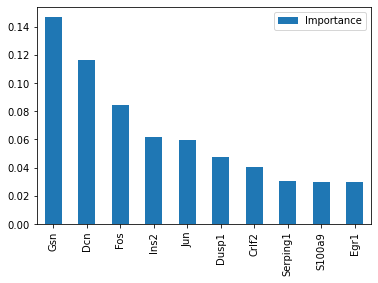

In [262]:
# visualizing the importance of the different features

impfeatures10.plot.bar()
plt.savefig('figures/impfeatures_10_inter')

In [265]:
# Making the intersection Rubin dataset

rubin_data_overlap_inter_pd = pd.DataFrame(rubin_data_overlap_inter.X.toarray(), columns = rubin_data_overlap_inter.var.index.tolist(), index = rubin_data_overlap_inter.obs.all_cells_by_age.tolist())
rubin_age_label_inter_pd = rubin_data_overlap_inter.obs.all_cells_by_age

X_rubin_test_inter = rubin_data_overlap_inter_pd
y_rubin_test_inter = rubin_age_label_inter_pd
y_rubin_test_inter = y_rubin_test_inter.replace({'2-3mo':'3m', '21-22mo':'24m'})


In [266]:
cv_score_train_inter = cross_val_score(clf_inter, X_train_inter, y_train_inter)
cv_score_test_inter = cross_val_score(clf_inter, X_test_inter, y_test_inter)
cv_score_test_rubin_inter = cross_val_score(clf_inter, X_rubin_test_inter, y_rubin_test_inter)

print('training score TMS intersection: ', cv_score_train_inter)
print('testing score TMS intersection: ', cv_score_test_inter)
print('testing score Rubin intersection: ', cv_score_test_rubin_inter)
      

training score TMS intersection:  [0.94773251 0.95926211 0.95541891 0.96692308 0.94846154]
testing score TMS intersection:  [0.94623656 0.94802867 0.94802867 0.95152603 0.9497307 ]
testing score Rubin intersection:  [0.6265252  0.65411141 0.6029724  0.58864119 0.59872611]


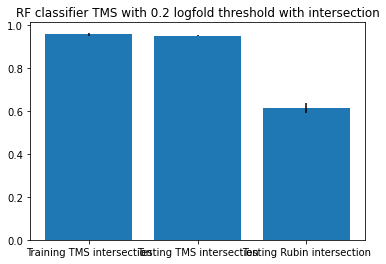

In [258]:
# plotting the results

score_plot_rubin = pd.DataFrame(index = ['Training TMS intersection', 'Testing TMS intersection', 'Testing Rubin intersection'], columns = ['Score'])
score_plot_rubin['Score'] = [np.mean(cv_score_train_inter), np.mean(cv_score_test_inter), np.mean(cv_score_test_rubin_inter)]

plt.bar(np.arange(len(score_plot_rubin['Score'])), score_plot_rubin['Score'], yerr = [np.std(cv_score_train_inter), np.std(cv_score_test_inter), np.std(cv_score_test_rubin_inter)])
plt.xticks(np.arange(len(score_plot_rubin['Score'])), score_plot_rubin.index)
plt.title('RF classifier TMS with 0.2 logfold threshold with intersection')
plt.savefig('figures/RF classifier TMS with intersection')

In [267]:
# plot with visualization of the misclassification of the age groups

y_pred_test_inter_TMS = clf_inter.predict(X_test_inter)
y_pred_test_inter_rubin = clf_inter.predict(X_rubin_test_inter)

matrix_TMS = confusion_matrix(y_test_inter.to_numpy(), y_pred_test_inter_TMS, labels=['3m', '24m'])
res_TMS = matrix_TMS.diagonal()/matrix_TMS.sum(axis=1)
print('matrix_TMS: ', res_TMS)

matrix_rubin = confusion_matrix(y_rubin_test_inter.to_numpy(), y_pred_test_inter_rubin, labels=['3m', '24m'])
res = matrix_rubin.diagonal()/matrix_rubin.sum(axis=1)
print('matrix_rubin: ', res)


matrix_TMS:  [0.95845481 0.95127119]
matrix_rubin:  [0.28428608 0.68628872]


### GSEA

In [377]:
import gseapy
gene_set_names = gseapy.get_library_name(organism='Mouse') # get the gene set names for humans
print(gene_set_names)


['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

In [378]:
sc.tl.rank_genes_groups(lee_rubin_mouse, 'ages', method='wilcoxon', key_added = "wilcoxon")

In [393]:
enr_res_inter = gseapy.enrichr(gene_list=genes_train_Inter.tolist(), organism='Human', gene_sets='GO_Biological_Process_2018',description='pathway', cutoff = 0.2) # value from range(0,1)

print(enr_res.results.head())

                     Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0  positive regulation of leukocyte chemotaxis (G...   13/61  2.803076e-09   
1  positive regulation of mononuclear cell migrat...    7/19  2.272550e-07   
2   cytokine-mediated signaling pathway (GO:0019221)  39/633  2.357367e-07   
3  chemokine-mediated signaling pathway (GO:0070098)   10/52  5.375813e-07   
4                 eosinophil chemotaxis (GO:0048245)    7/24  1.400392e-06   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000007            0                     0   10.817762   
1          0.000197            0                     0   23.058824   
2          0.000197            0                     0    2.692631   
3          0.000337            0                    

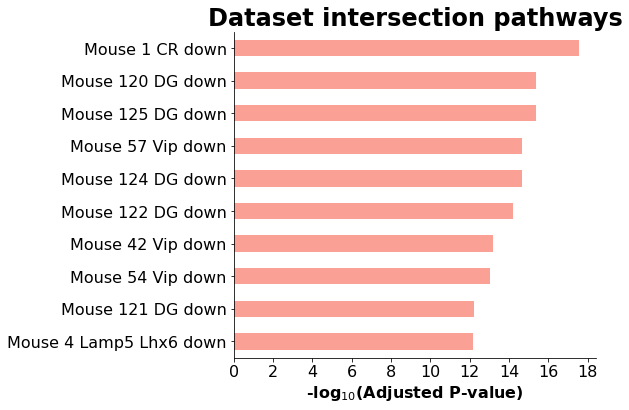

In [380]:
gseapy.barplot(enr_res_inter.res2d,title='Dataset intersection pathways')
plt.savefig('figures/Dataset intersection pathways.png')

In [394]:
enr_res_TM = gseapy.enrichr(gene_list=genes_train_TM.tolist(), organism='Mouse', gene_sets='GO_Biological_Process_2018', description='pathway', cutoff = 0.2) # value from range(0,1)

print(enr_res.results.head())


                     Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0  positive regulation of leukocyte chemotaxis (G...   13/61  2.803076e-09   
1  positive regulation of mononuclear cell migrat...    7/19  2.272550e-07   
2   cytokine-mediated signaling pathway (GO:0019221)  39/633  2.357367e-07   
3  chemokine-mediated signaling pathway (GO:0070098)   10/52  5.375813e-07   
4                 eosinophil chemotaxis (GO:0048245)    7/24  1.400392e-06   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000007            0                     0   10.817762   
1          0.000197            0                     0   23.058824   
2          0.000197            0                     0    2.692631   
3          0.000337            0                    

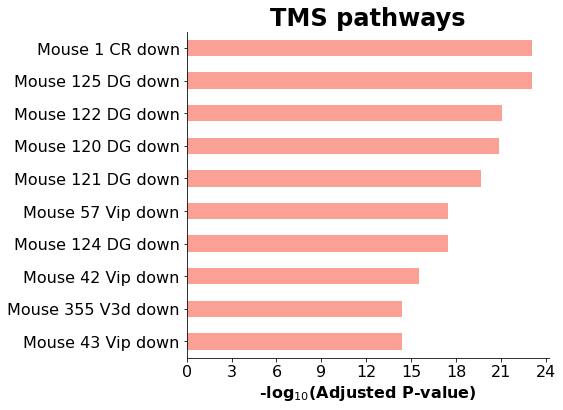

In [382]:
gseapy.barplot(enr_res_TM.res2d,title='TMS pathways')
plt.savefig('figures/TMS pathways.png')

In [383]:
genes_rubin = lee_rubin_mouse.uns['rank_genes_groups']['names']['21-22mo'][np.argsort(-np.abs(lee_rubin_mouse.uns['rank_genes_groups']['logfoldchanges']['21-22mo']))][:500]
enr_res_rubin = gseapy.enrichr(gene_list=genes_rubin.tolist(), organism='Human', gene_sets='GO_Biological_Process_2018', description='pathway', cutoff = 0.2) # value from range(0,1)

print(enr_res.results.head())

                     Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0  positive regulation of leukocyte chemotaxis (G...   13/61  2.803076e-09   
1  positive regulation of mononuclear cell migrat...    7/19  2.272550e-07   
2   cytokine-mediated signaling pathway (GO:0019221)  39/633  2.357367e-07   
3  chemokine-mediated signaling pathway (GO:0070098)   10/52  5.375813e-07   
4                 eosinophil chemotaxis (GO:0048245)    7/24  1.400392e-06   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000007            0                     0   10.817762   
1          0.000197            0                     0   23.058824   
2          0.000197            0                     0    2.692631   
3          0.000337            0                    

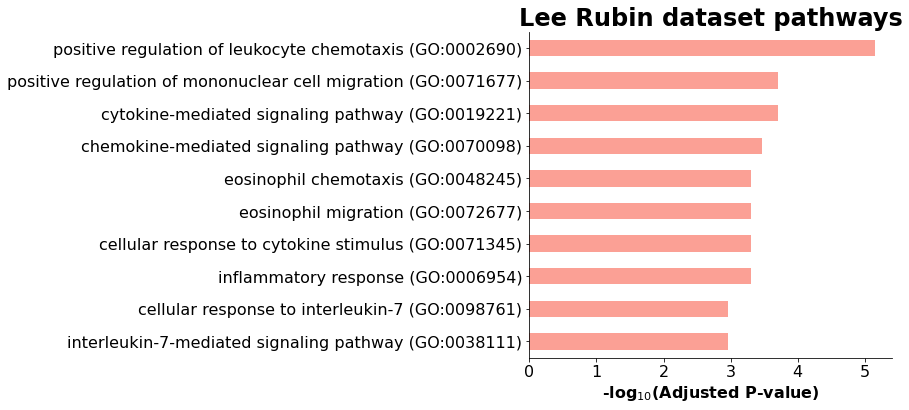

In [384]:
gseapy.barplot(enr_res_rubin.res2d,title='Lee Rubin dataset pathways')
plt.savefig('figures/Lee Rubin pathways.png')

In [385]:
genes_rubin = lee_rubin_mouse.uns['rank_genes_groups']['names']['21-22mo'][np.argsort(-np.abs(lee_rubin_mouse.uns['rank_genes_groups']['logfoldchanges']['21-22mo']))][:500]

In [386]:
genes_train_TM = tabula_muris_mouse.uns['rank_genes_groups']['names']['24m'][np.argsort(-np.abs(tabula_muris_mouse.uns['rank_genes_groups']['logfoldchanges']['24m']))][:500]

In [395]:
gseapy.get_library_name(organism='Human')

enr_rubin = gseapy.enrichr(gene_list=genes_rubin.tolist(), gene_sets=['Allen_Brain_Atlas_10x_scRNA_2021'],organism='Mouse',cutoff=0.1) # test dataset, use lower value from range(0,1)) 
enr_rubin.results.head(5)
                     

2022-05-08 21:38:16,187 Warning: No enrich terms using library Allen_Brain_Atlas_10x_scRNA_2021 when cutoff = 0.1


Gene_set                           Term Overlap  \
0  Allen_Brain_Atlas_10x_scRNA_2021  Human Inh L1-3 VIP FNDC1 down    3/15   
1  Allen_Brain_Atlas_10x_scRNA_2021             Mouse 358 Astro up   7/100   
2  Allen_Brain_Atlas_10x_scRNA_2021         Mouse 324 L6 CT CTX up    5/61   
3  Allen_Brain_Atlas_10x_scRNA_2021      Mouse 153 L2 IT ENTm down     2/9   
4  Allen_Brain_Atlas_10x_scRNA_2021      Mouse 138 L2 IT ENTl down    2/10   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.005648          0.999995            0                     0    9.802817   
1  0.012749          0.999995            0                     0    2.962965   
2  0.018082          0.999995            0                     0    3.507215   
3  0.019987          0.999995            0                     0   11.183592   
4  0.024576          0.999995            0                     0    9.785141   

   Combined Score                                       Genes  
0       50.743786                        PLEKHA1;RAPGEF5;ELL2  
1       12.925368  TMEM47;ALDH1L1;GSTM1;ALDOC;NDRG2;CLU;FADS1  
2       14.073836     SLC35F3;LSP1;LYST;KAZALD1;4732471J01RIK  
3       43.757460                                  AHI1;LRP1B  
4       36.263707                                   AHI1;EBF1

In [388]:
enr_tms = gseapy.enrichr(gene_list=genes_train_TM.tolist(), gene_sets=['Allen_Brain_Atlas_10x_scRNA_2021'],organism='Human',cutoff=0.1) # test dataset, use lower value from range(0,1)) 
enr_tms.results.head(5)
                         

Gene_set               Term Overlap       P-value  \
0  Allen_Brain_Atlas_10x_scRNA_2021    Mouse 1 CR down  78/769  1.568960e-26   
1  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 125 DG down  58/425  2.438211e-26   
2  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 122 DG down  52/373  4.008101e-24   
3  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 120 DG down  56/442  7.960396e-24   
4  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 121 DG down  50/372  1.661956e-22   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      8.216772e-24            0                     0    5.031179   
1      8.216772e-24            0                     0    6.841049   
2      9.004867e-22            0                     0    6.934997   
3      1.341327e-21            0                     0    6.245531   
4      2.240316e-20            0                     0    6.617667   

   Combined Score                                              Genes  
0      298.936582  PCSK2;NCKAP1;DOCK3;DGKB;DENND5B;OTUD7A;PNMAL2;...  
1      403.457377  TMEM151A;RAB3C;CNTNAP2;CSRNP3;CLSTN3;DENND5B;S...  
2      373.614101  TMEM151A;RAB3C;CNTNAP2;CSRNP3;CLSTN3;DENND5B;S...  
3      332.184551  RAB3C;CNTNAP2;DENND5B;STMN3;FAIM2;FMN2;ZCCHC18...  
4      331.868586  TMEM151A;RAB3C;CNTNAP2;CSRNP3;CLSTN3;DENND5B;S...

In [389]:
enr_inter = gseapy.enrichr(gene_list=genes_train_Inter.tolist(), gene_sets=['Allen_Brain_Atlas_10x_scRNA_2021'],organism='Human',cutoff=0.1) # test dataset, use lower value from range(0,1)) 
enr_inter.results.head(5)
                         

Gene_set               Term Overlap       P-value  \
0  Allen_Brain_Atlas_10x_scRNA_2021    Mouse 1 CR down  70/769  4.016149e-21   
1  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 120 DG down  49/442  1.803768e-18   
2  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 125 DG down  48/425  1.914616e-18   
3  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 57 Vip down  34/220  1.547700e-17   
4  Allen_Brain_Atlas_10x_scRNA_2021  Mouse 124 DG down  35/235  1.704170e-17   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.682788e-18            0                     0    4.378581   
1      4.263211e-16            0                     0    5.282257   
2      4.263211e-16            0                     0    5.386634   
3      2.276771e-15            0                     0    7.576215   
4      2.276771e-15            0                     0    7.263441   

   Combined Score                                              Genes  
0      205.635504  GABRB3;PCSK2;NCKAP1;DOCK3;DGKB;DENND5B;OTUD7A;...  
1      215.815329  CNTNAP2;DENND5B;STMN3;FAIM2;FMN2;ZCCHC18;SERP2...  
2      219.758591  TMEM151A;CNTNAP2;CSRNP3;CLSTN3;DENND5B;HSPA4L;...  
3      293.253885  TMEM151A;NCKAP1;FAIM2;FMN2;AK5;SERP2;GRIN2A;ZF...  
4      280.447758  TMEM151A;CNTNAP2;CLSTN3;DENND5B;HSPA4L;KCNA2;S...

In [390]:
gseapy.barplot(enr_rubin.res2d,title='Lee Rubin dataset pathways')
plt.savefig('figures/Lee Rubin pathways Allen.png')

<Figure size 432x288 with 0 Axes>

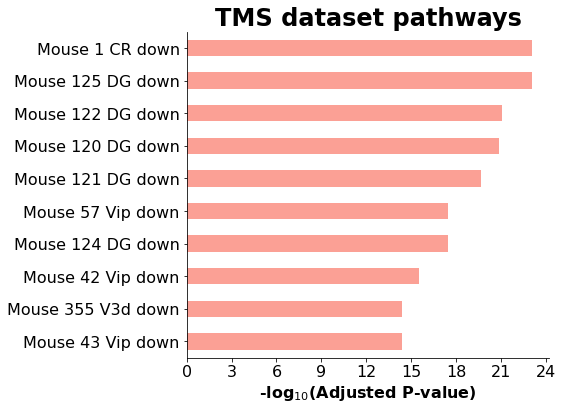

In [391]:
gseapy.barplot(enr_tms.res2d,title='TMS dataset pathways')
plt.savefig('figures/TMS pathways Allen.png')

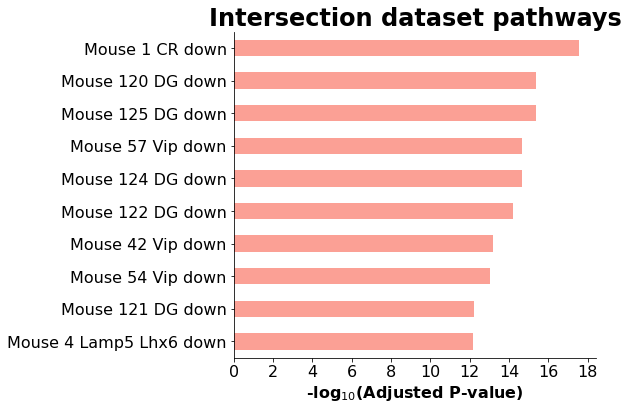

In [392]:
gseapy.barplot(enr_inter.res2d,title='Intersection dataset pathways')
plt.savefig('figures/Intersection pathways Allen.png')